## Diabetes Modeling

This notebook contains models for predicting diabetes. 

There are examples of all sorts of models, and in particular, they are contrasted with SNNs (self-normalizing neural networks) see:

https://arxiv.org/abs/1706.02515

and

https://github.com/bioinf-jku/SNNs

for more information on SNNs.  SNNs provide a simple yet grounded way to create deep models on "generic data" meaning not image, text or speech data. That said, you could apply them to those domains as well.

We'll work with this dataset:

https://archive.ics.uci.edu/ml/datasets/Diabetes

Here's a link to processed UCI data:

http://www.bioinf.jku.at/people/klambauer/data_py.zip

### first use _these_ data

I'm going to download  simple csv from kaggle --this is a subset

https://www.kaggle.com/uciml/pima-indians-diabetes-database/data

Reference: Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.


http://rexa.info/paper/04587c10a7c92baa01948f71f2513d5928fe8e81

### other slightly related data for later

More diabetes data for further investigation:

https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

https://catalog.data.gov/dataset?tags=diabetes

```
from sklearn import datasets
diabetes = datasets.load_diabetes()
diabetes
```

In [1]:
import sys, os
import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter

In [2]:
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [3]:
import matplotlib
matplotlib.style.use('ggplot')
import itertools

In [155]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, AlphaDropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.models import Model, Input

from keras.utils.np_utils import to_categorical

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import Ridge, Lasso


import warnings
warnings.filterwarnings('ignore')

In [156]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
from sklearn.model_selection import cross_val_score

from sklearn.grid_search import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [8]:
import xgboost as xgb

## Load data

Attributes
-------

**Pregnancies**: Number of times pregnant

**Glucose**: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

**BloodPressure**: Diastolic blood pressure (mm Hg)

**SkinThickness**: Triceps skin fold thickness (mm)

**Insulin**: 2-Hour serum insulin (mu U/ml)

**BMI**: Body mass index (weight in kg/(height in m)^2)

**DiabetesPedigreeFunction**: Diabetes pedigree function

**Age**: Age (years)

**Outcome**: Class variable (0=non diabetic or 1=diabetic)


We'll need to load the data and manipulate it a bit.

In [9]:
df = pd.read_csv('pima_diabetes_subset.csv')
len(df)

768

In [10]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [11]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Imputation

While we are not missing values some have been filled with nonsense, these can't be zero:
- SkinThickness
- Insulin
- BMI
- Glucose
- Blood pressure

we'll replace zero values with the median.

In [13]:
median_skinthickness = df['SkinThickness'].median()
median_insulin = df['Insulin'].median()
median_bmi = df['BMI'].median()
median_glucose = df['Glucose'].median()
median_skinthickness, median_insulin, median_bmi, median_glucose

(23.0, 30.5, 32.0, 117.0)

In [14]:
median_blood_pressure = df['BloodPressure'].median()
median_blood_pressure

72.0

In [15]:
df['SkinThickness'] = df['SkinThickness'].apply(lambda x: median_skinthickness if x == 0 else x)
df['SkinThickness'].describe()

count    768.000000
mean     27.334635 
std      9.229014  
min      7.000000  
25%      23.000000 
50%      23.000000 
75%      32.000000 
max      99.000000 
Name: SkinThickness, dtype: float64

In [16]:
df['Insulin'] = df['Insulin'].apply(lambda x: median_insulin if x == 0 else x)
df['Insulin'].describe()

count    768.000000
mean     94.652344 
std      105.547598
min      14.000000 
25%      30.500000 
50%      31.250000 
75%      127.250000
max      846.000000
Name: Insulin, dtype: float64

In [17]:
df['BMI'] = df['BMI'].apply(lambda x: median_bmi if x == 0 else x)
df['BMI'].describe()

count    768.000000
mean     32.450911 
std      6.875366  
min      18.200000 
25%      27.500000 
50%      32.000000 
75%      36.600000 
max      67.100000 
Name: BMI, dtype: float64

In [18]:
df['Glucose'] = df['Glucose'].apply(lambda x: median_glucose if x == 0 else x)
df['Glucose'].describe()

count    768.000000
mean     121.656250
std      30.438286 
min      44.000000 
25%      99.750000 
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64

In [19]:
df['BloodPressure'] = df['BloodPressure'].apply(lambda x: median_blood_pressure if x == 0 else x)
df['BloodPressure'].describe()

count    768.000000
mean     72.386719 
std      12.096642 
min      24.000000 
25%      64.000000 
50%      72.000000 
75%      80.000000 
max      122.000000
Name: BloodPressure, dtype: float64

## Visualization

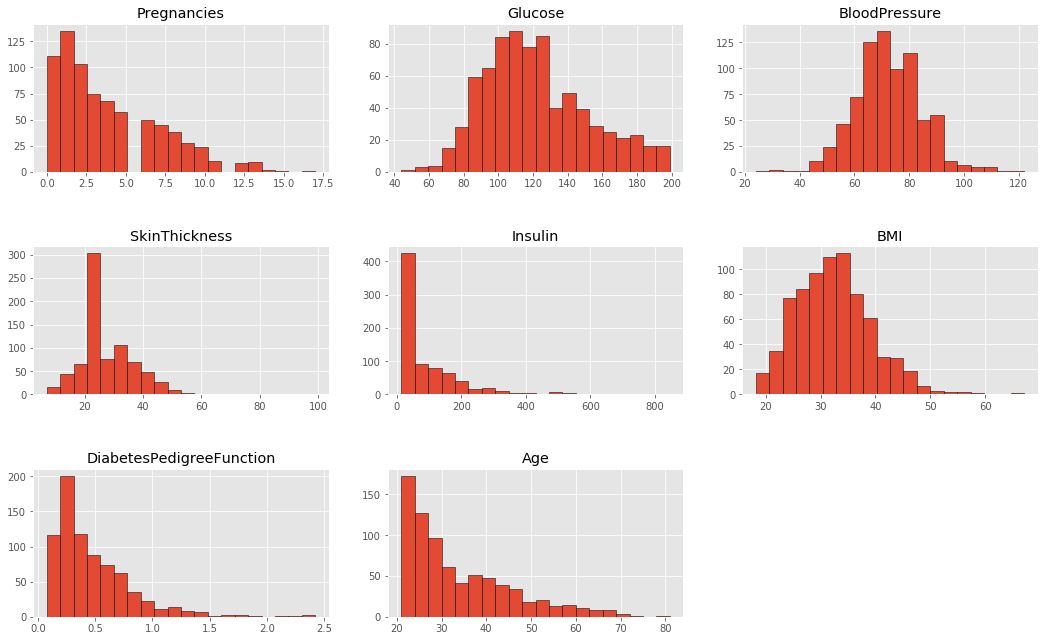

In [20]:
columns=df.columns[:8]
plt.subplots(figsize=(18,15))
length=len(columns)
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot((length/2),3,j+1)
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    df[i].hist(bins=20,edgecolor='black')
    plt.title(i)
plt.show()

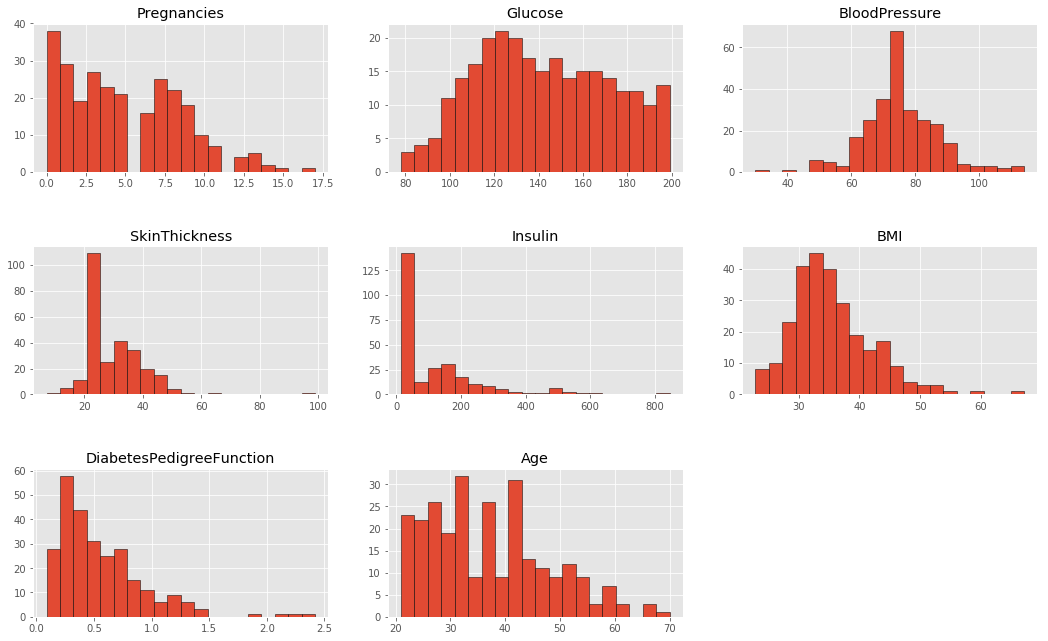

In [21]:
# Diabetes only
diab1=df[df['Outcome']==1]
columns=diab1.columns[:8]
plt.subplots(figsize=(18,15))
length=len(columns)
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot((length/2),3,j+1)
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    diab1[i].hist(bins=20,edgecolor='black')
    plt.title(i)
plt.show()

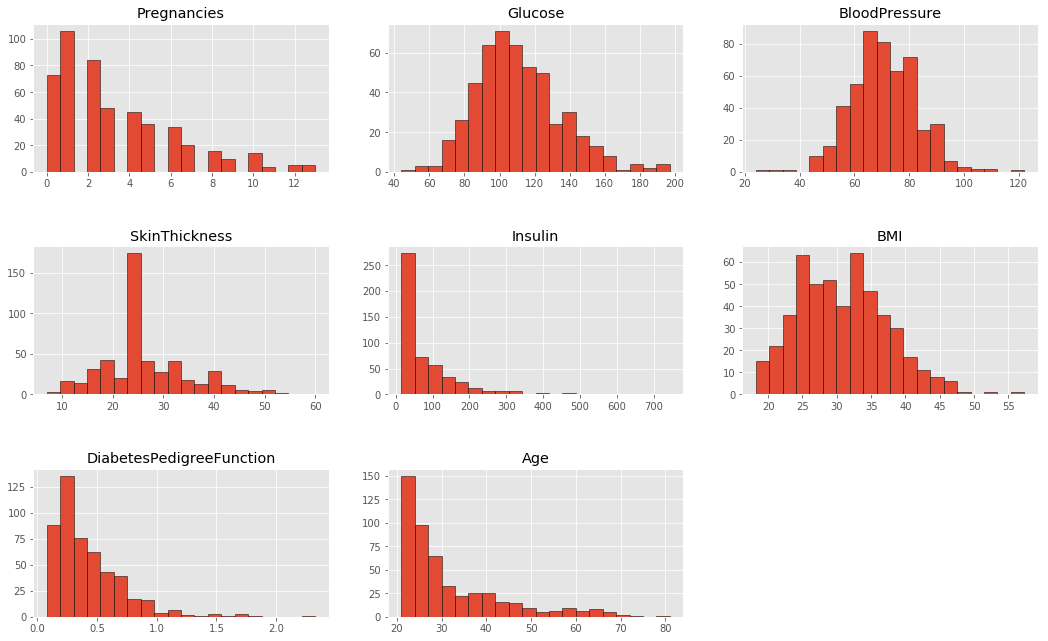

In [22]:
# Non diabetes
diab0=df[df['Outcome']==0]
columns=diab0.columns[:8]
plt.subplots(figsize=(18,15))
length=len(columns)
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot((length/2),3,j+1)
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    diab0[i].hist(bins=20,edgecolor='black')
    plt.title(i)
plt.show()

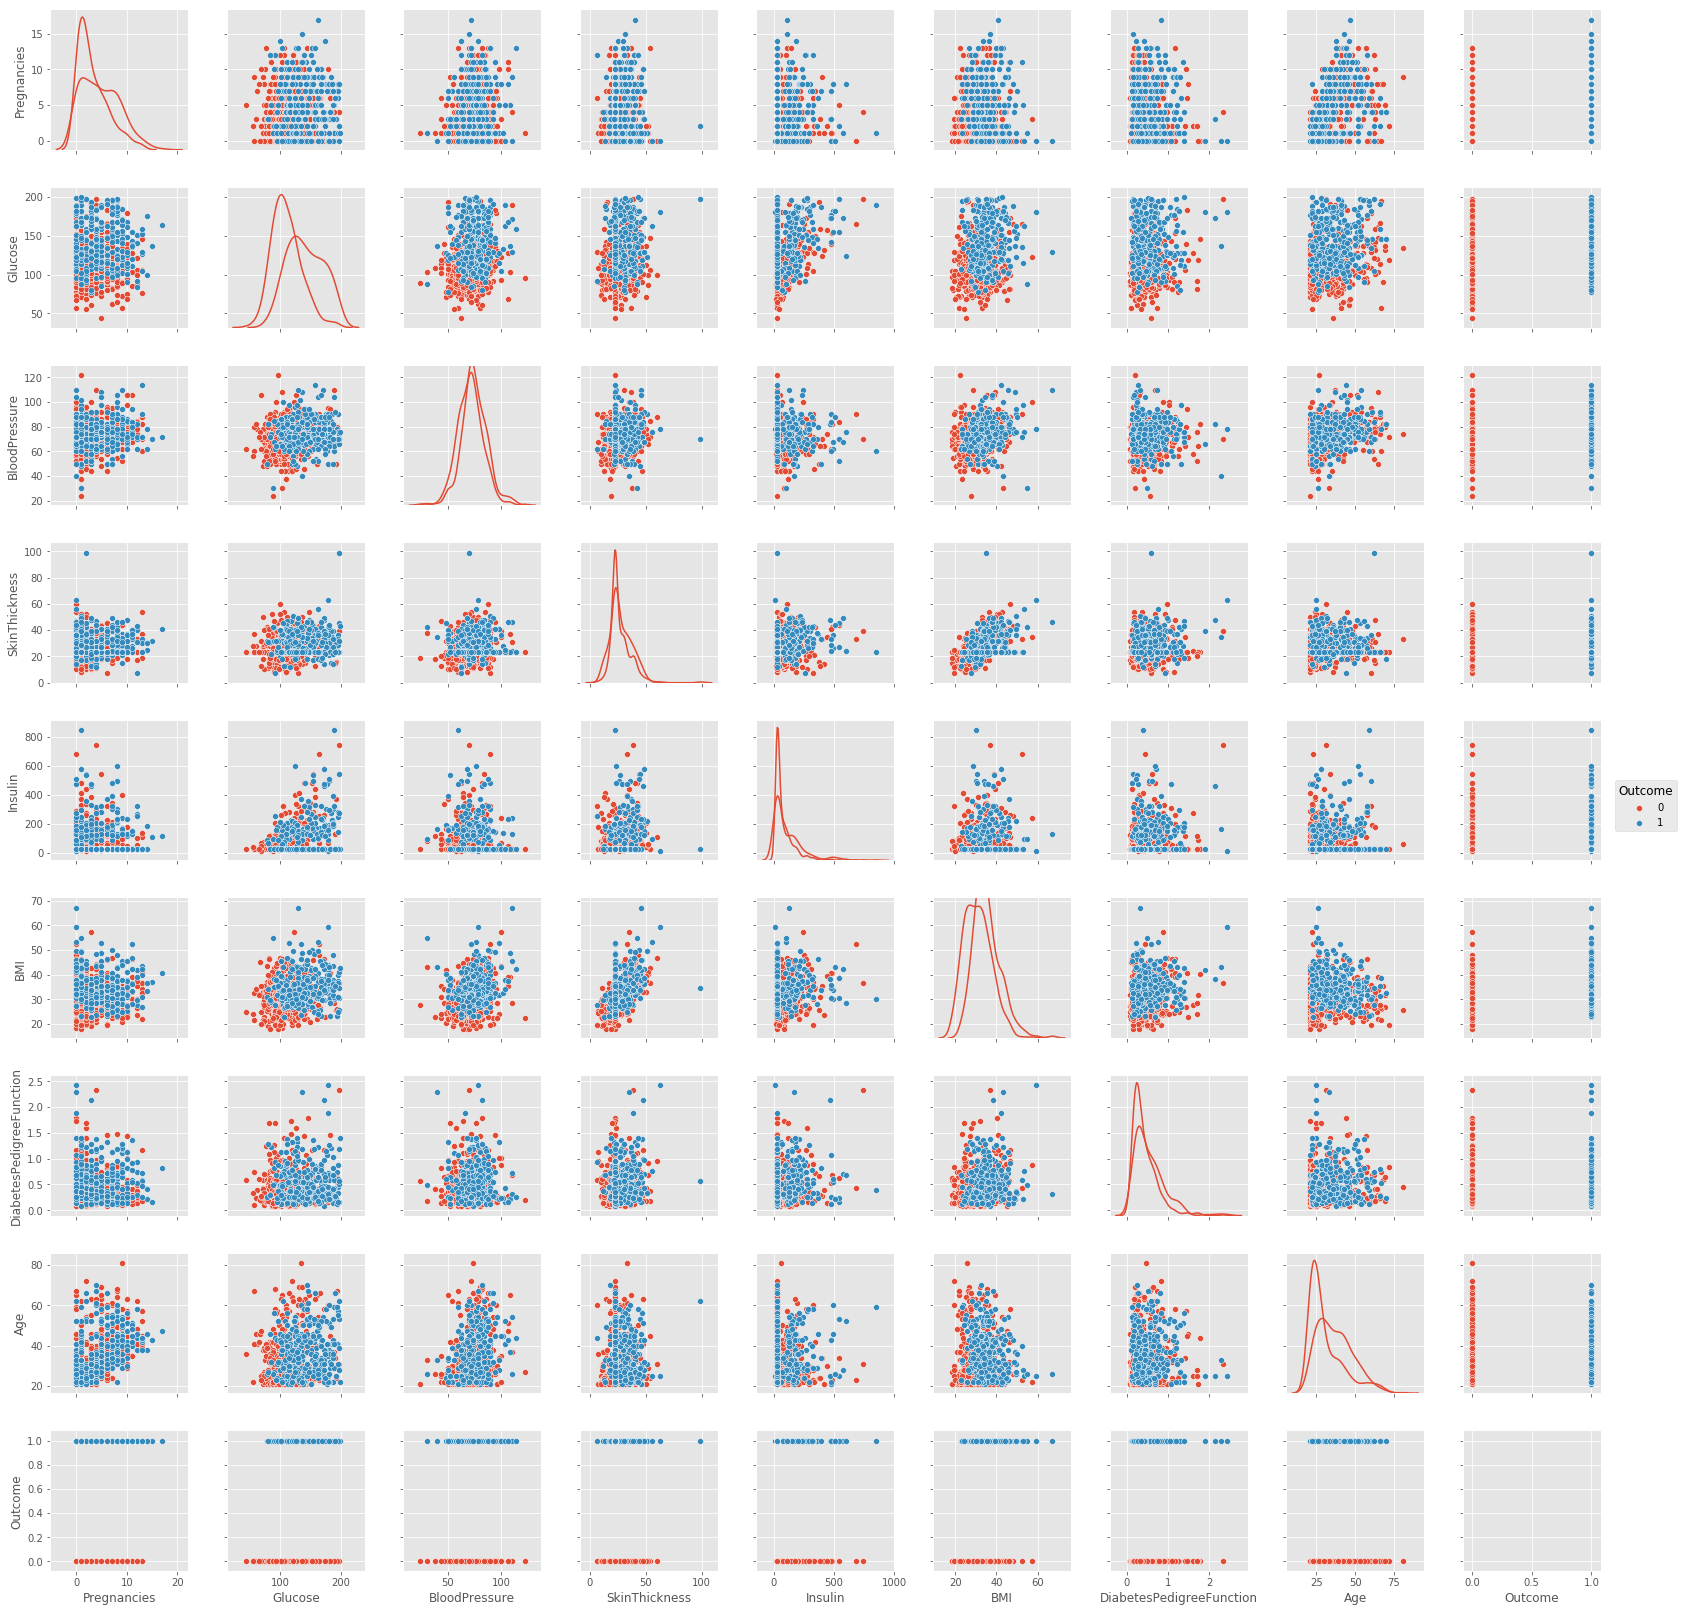

In [23]:
# these are good for looking for non-linear relationships
sns.pairplot(data=df,hue='Outcome',diag_kind='kde')
plt.show()

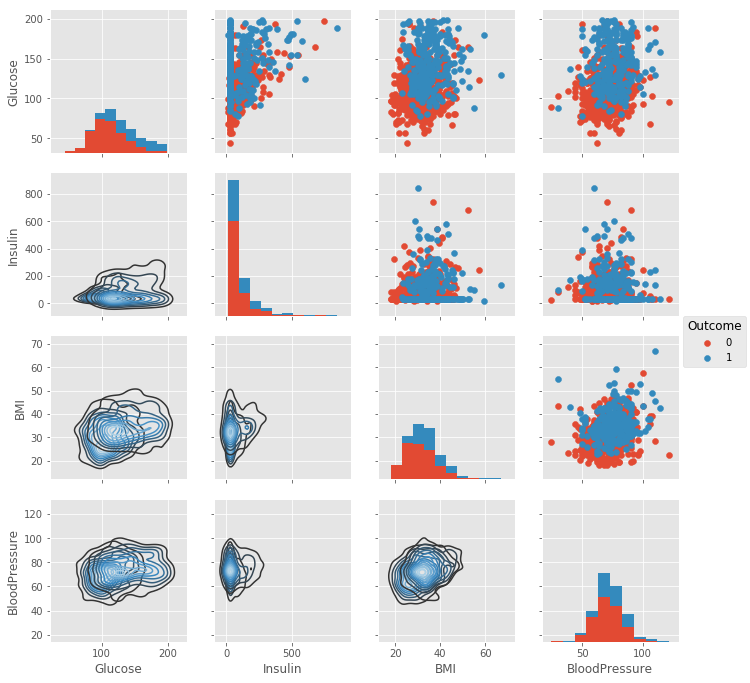

In [24]:
g = sns.PairGrid(df, vars=['Glucose', 'Insulin', 'BMI', 'BloodPressure'], hue="Outcome", size=2.4)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.add_legend()
plt.show()

### Check balance of dataset

In [25]:
df['Outcome'].sum()

268

#### If we predict only 0 on all data (majority class) we'll get the following accuracy

In [26]:
1 - df['Outcome'].sum() / len(df)

0.6510416666666667

In [27]:
df.columns, len(df.columns)

(Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
        'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
       dtype='object'), 9)

In [28]:
cols = df.columns
train_cols = cols[0:8]
test_col = cols[8]

In [29]:
X = df[train_cols].values
X.shape

(768, 8)

In [30]:
y = df[test_col].values
y.shape

(768,)

## Split data

we have a pretty small dataset so we'll use a 1/3 validation split.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((514, 8), (254, 8), (514,), (254,))

## Scale data

While decision tree methods don't really need this some of our other methods should benifit from scaling.

In [33]:
scaler = MinMaxScaler()

In [34]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
Xs = scaler.transform(X)

In [35]:
X_train

array([[ 0.58823529,  0.45806452,  0.75510204, ...,  0.11860941,
         0.4030743 ,  0.21666667],
       [ 0.41176471,  0.63225806,  0.36734694, ...,  0.21676892,
         0.26003416,  0.66666667],
       [ 0.23529412,  0.46451613,  0.48979592, ...,  0.0797546 ,
         0.16438941,  0.26666667],
       ..., 
       [ 0.58823529,  0.36774194,  0.63265306, ...,  0.5603272 ,
         0.45175064,  0.28333333],
       [ 0.        ,  0.62580645,  0.48979592, ...,  0.49488753,
         0.05422716,  0.13333333],
       [ 0.        ,  0.52258065,  0.73469388, ...,  0.08793456,
         0.07856533,  0.        ]])

In [111]:
Y = to_categorical(y)
Y.shape

(768, 2)

In [37]:
Y_test = to_categorical(y_test)
Y_test.shape

(254, 2)

In [38]:
Y_train = to_categorical(y_train)
Y_train.shape

(514, 2)

In [39]:
X_train.shape, Y_train.shape

((514, 8), (514, 2))

In [40]:
X_test.shape, Y_test.shape

((254, 8), (254, 2))

#### max accuracy on majority class for splits

In [41]:
(1-y_train.sum()/len(y_train)), (1- y_test.sum()/len(y_test))

(0.64591439688715946, 0.6614173228346456)

## Univariate models

It's good practice to check one by one to see which features are predictive

In [42]:
def report_scores(y_true, y_pred):
    print('accuracy: ', accuracy_score(y_true, y_pred))
    print('recall:   ', recall_score(y_true, y_pred, average='macro'))
    print('precision:', precision_score(y_true, y_pred, average='macro'))
    print('f1 score: ', f1_score(y_true, y_pred, average='macro'))
    print('confusion matrix:\n', confusion_matrix(y_true, y_pred))
    return

In [161]:
def report_loss_scores(y_true_cat, y_pred_probs):
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_true_cat, axis=1)
    print('the loss: ', log_loss(y_true_cat, y_pred_probs))
    print('accuracy: ', accuracy_score(y_true, y_pred))
    print('recall:   ', recall_score(y_true, y_pred, average='macro'))
    print('precision:', precision_score(y_true, y_pred, average='macro'))
    print('f1 score: ', f1_score(y_true, y_pred, average='macro'))
    print('confusion matrix:\n', confusion_matrix(y_true, y_pred))
    return

In [158]:
# overall check
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [159]:
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)

training:
accuracy:  0.772373540856
recall:    0.717049516748
precision: 0.766841644794
f1 score:  0.729316607478
confusion matrix:
 [[301  31]
 [ 86  96]]

validation:
accuracy:  0.748031496063
recall:    0.696013289037
precision: 0.719875776398
f1 score:  0.703962703963
confusion matrix:
 [[144  24]
 [ 40  46]]


In [162]:
probs = model.predict_proba(X_test)
report_loss_scores(Y_test, probs)

the loss:  0.514641110968
accuracy:  0.748031496063
recall:    0.696013289037
precision: 0.719875776398
f1 score:  0.703962703963
confusion matrix:
 [[144  24]
 [ 40  46]]


In [45]:
type(X_train), X_train.shape

(numpy.ndarray, (514, 8))

In [46]:
for i, f in enumerate(train_cols):
    model = LogisticRegression()
    # reshape for single feature
    x_train = X_train[:,i].reshape(-1, 1)
    model.fit(x_train, y_train)
    x_test = X_test[:,i].reshape(-1, 1)
    predictions = model.predict(x_test)
    print('Model for feature:', f)
    report_scores(y_test, predictions)
    print()

Model for feature: Pregnancies
accuracy:  0.685039370079
recall:    0.56042358804
precision: 0.658152173913
f1 score:  0.535861123801
confusion matrix:
 [[159   9]
 [ 71  15]]

Model for feature: Glucose
accuracy:  0.724409448819
recall:    0.655454042082
precision: 0.69295532646
f1 score:  0.66358888973
confusion matrix:
 [[146  22]
 [ 48  38]]

Model for feature: BloodPressure
accuracy:  0.661417322835
recall:    0.502837763012
precision: 0.581349206349
f1 score:  0.408982683983
confusion matrix:
 [[167   1]
 [ 85   1]]

Model for feature: SkinThickness
accuracy:  0.661417322835
recall:    0.511351052049
precision: 0.583333333333
f1 score:  0.43868845719
confusion matrix:
 [[164   4]
 [ 82   4]]

Model for feature: Insulin
accuracy:  0.657480314961
recall:    0.502699335548
precision: 0.531325301205
f1 score:  0.417661475215
confusion matrix:
 [[165   3]
 [ 84   2]]

Model for feature: BMI
accuracy:  0.681102362205
recall:    0.560285160576
precision: 0.64211127427
f1 score:  0.53906

## Sklearn model zoo

let's try a bunch of models

In [47]:
def print_feature_importances(model, train_cols):
    print('Feature Importances')
    print('===================')
    for f, w in sorted(zip(train_cols, model.feature_importances_), key=lambda x: -x[1]):
        print('{:<50} {}'.format(f, w))
    return

### Check CV variations

We will use this function to also create out-of-fold (OOF) data. OOF data means the predictions on our the entire training dataset, but collected bit by bit from the validation folds. 

This OOF data will be useful for comparisons and ensembles.

In [48]:
model = LogisticRegression()
scores = cross_val_score(model, Xs, y, cv=5)
scores, sum(scores) / len(scores)

(array([ 0.75974026,  0.73376623,  0.76623377,  0.79084967,  0.77124183]),
 0.76436635260164665)

In [50]:
model = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(model, Xs, y, cv=5)
scores, sum(scores) / len(scores)

(array([ 0.73376623,  0.77272727,  0.69480519,  0.77777778,  0.73856209]),
 0.74352771411594942)

In [120]:
def cv_analysis(model, X, y, n=5):
    cv = KFold(n_splits=n)
    i=1
    f1s = []
    oof_predictions = np.zeros((X.shape[0], 2))
    for train_index, test_index in cv.split(X):
        print('Fold:', i)
        Xtrain, Xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        model.fit(Xtrain, ytrain)
        train_predictions = model.predict(Xtrain)
        val_predictions = model.predict(Xtest)
        print('training')
        report_scores(ytrain, train_predictions)
        print('\nvalidation:')
        report_scores(ytest, val_predictions)
        f1 = f1_score(ytest, val_predictions, average='macro')
        f1s.append(f1)
        probs = model.predict_proba(Xtest)
        oof_predictions[test_index] = probs
        i+=1
    print('\nMean F1:', sum(f1s)/len(f1s))
    return oof_predictions

In [121]:
model = KNeighborsClassifier(n_neighbors=5)
oof_knn_5 = cv_analysis(model, Xs, y, 5)

Fold: 1
training
accuracy:  0.807817589577
recall:    0.774275700935
precision: 0.793152532215
f1 score:  0.781805259417
confusion matrix:
 [[354  46]
 [ 72 142]]

validation:
accuracy:  0.733766233766
recall:    0.692777777778
precision: 0.70699940346
f1 score:  0.697995886545
confusion matrix:
 [[83 17]
 [24 30]]
Fold: 2
training
accuracy:  0.820846905537
recall:    0.785808225729
precision: 0.802135995956
f1 score:  0.792771232204
confusion matrix:
 [[365  45]
 [ 65 139]]

validation:
accuracy:  0.733766233766
recall:    0.715798611111
precision: 0.728282828283
f1 score:  0.719265483971
confusion matrix:
 [[74 16]
 [25 39]]
Fold: 3
training
accuracy:  0.812703583062
recall:    0.779420930697
precision: 0.796673658975
f1 score:  0.786529048798
confusion matrix:
 [[357  46]
 [ 69 142]]

validation:
accuracy:  0.753246753247
recall:    0.710074154458
precision: 0.743347999162
f1 score:  0.718653846154
confusion matrix:
 [[85 12]
 [26 31]]
Fold: 4
training
accuracy:  0.819512195122
reca

In [58]:
oof_knn_5.shape

(768, 2)

In [257]:
report_loss_scores(Y, oof_knn_5)

the loss:  1.54693953928
accuracy:  0.7421875
recall:    0.706776119403
precision: 0.715774226708
f1 score:  0.710524111569
confusion matrix:
 [[412  88]
 [110 158]]


In [59]:
preds = np.argmax(oof_knn_5, axis =1)
accuracy_score(y, preds)

0.7421875

In [60]:
oof_logreg = cv_analysis(LogisticRegression(), Xs, y, 5)

Fold: 1
training
accuracy:  0.773615635179
recall:    0.716518691589
precision: 0.765100911132
f1 score:  0.729056016762
confusion matrix:
 [[362  38]
 [101 113]]

validation:
accuracy:  0.75974025974
recall:    0.704259259259
precision: 0.745930880713
f1 score:  0.715028757189
confusion matrix:
 [[89 11]
 [26 28]]
Fold: 2
training
accuracy:  0.78338762215
recall:    0.719583931133
precision: 0.770068377325
f1 score:  0.733801434947
confusion matrix:
 [[373  37]
 [ 96 108]]

validation:
accuracy:  0.694805194805
recall:    0.662152777778
precision: 0.695684056149
f1 score:  0.66345840889
confusion matrix:
 [[77 13]
 [34 30]]
Fold: 3
training
accuracy:  0.775244299674
recall:    0.713628826456
precision: 0.767120064701
f1 score:  0.727051334914
confusion matrix:
 [[367  36]
 [102 109]]

validation:
accuracy:  0.779220779221
recall:    0.72707542051
precision: 0.790020790021
f1 score:  0.739709683834
confusion matrix:
 [[90  7]
 [27 30]]
Fold: 4
training
accuracy:  0.752845528455
recall:

In [61]:
preds = np.argmax(oof_logreg, axis =1)
f1_score(y, preds, average='macro')

0.71950158906320949

## back to model exploration

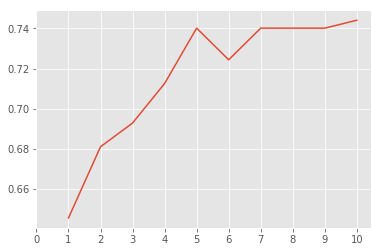

Accuracies for different values of n are: [ 0.64566929  0.68110236  0.69291339  0.71259843  0.74015748  0.72440945
  0.74015748  0.74015748  0.74015748  0.74409449]


In [60]:
# KNN
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(X_train,y_train)
    prediction=model.predict(X_test)
    a=a.append(pd.Series(metrics.accuracy_score(y_test, prediction)))
plt.plot(a_index, a)
plt.xticks(x)
plt.show()
print('Accuracies for different values of n are:',a.values)


In [61]:
abc=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=4),DecisionTreeClassifier()]
for i in models:
    model = i
    model.fit(X_train, y_train)
    prediction=model.predict(X_test)
    abc.append(accuracy_score(y_test, prediction))
models_dataframe=pd.DataFrame(abc,index=classifiers)   
models_dataframe.columns=['Accuracy']
models_dataframe

,Accuracy
Linear Svm,0.736220
Radial Svm,0.759843
Logistic Regression,0.748031
KNN,0.712598
Decision Tree,0.708661


In [62]:
model = KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
                             weights='uniform')
model.fit(X_train, y_train)


train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)

training:
accuracy:  0.828793774319
recall:    0.79920230372
precision: 0.819191384181
f1 score:  0.807205087549
confusion matrix:
 [[299  33]
 [ 55 127]]

validation:
accuracy:  0.740157480315
recall:    0.701411960133
precision: 0.709051724138
f1 score:  0.704713591207
confusion matrix:
 [[138  30]
 [ 36  50]]


In [63]:
model =  Ridge()
model.fit(X_train, Y_train)

train_predictions = np.argmax(model.predict(X_train), axis=1)
val_predictions = np.argmax(model.predict(X_test),axis=1)

print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)

training:
accuracy:  0.770428015564
recall:    0.721749635906
precision: 0.758229263028
f1 score:  0.732291666667
confusion matrix:
 [[295  37]
 [ 81 101]]

validation:
accuracy:  0.744094488189
recall:    0.698712624585
precision: 0.713854748603
f1 score:  0.7044767036
confusion matrix:
 [[141  27]
 [ 38  48]]


In [64]:
model =  Ridge(alpha=0.1)
model.fit(X_train, Y_train)

train_predictions = np.argmax(model.predict(X_train), axis=1)
val_predictions = np.argmax(model.predict(X_test),axis=1)

print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)

training:
accuracy:  0.77626459144
recall:    0.728750165497
precision: 0.765170263789
f1 score:  0.739542712616
confusion matrix:
 [[296  36]
 [ 79 103]]

validation:
accuracy:  0.744094488189
recall:    0.698712624585
precision: 0.713854748603
f1 score:  0.7044767036
confusion matrix:
 [[141  27]
 [ 38  48]]


In [69]:
model =  Lasso(alpha=0.01, max_iter=100000)
model.fit(X_train, Y_train)

train_predictions = np.argmax(model.predict(X_train), axis=1)
val_predictions = np.argmax(model.predict(X_test),axis=1)

print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)

training:
accuracy:  0.766536964981
recall:    0.705084072554
precision: 0.765194316042
f1 score:  0.717582417582
confusion matrix:
 [[304  28]
 [ 92  90]]

validation:
accuracy:  0.748031496063
recall:    0.6875
precision: 0.722779605263
f1 score:  0.697281191806
confusion matrix:
 [[147  21]
 [ 43  43]]


In [117]:
model =  Lasso(alpha=0.00001, max_iter=100000)
model.fit(X_train, Y_train)

train_predictions = np.argmax(model.predict(X_train), axis=1)
val_predictions = np.argmax(model.predict(X_test),axis=1)

print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)

training:
accuracy:  0.778210116732
recall:    0.731497418244
precision: 0.767150496562
f1 score:  0.74224482255
confusion matrix:
 [[296  36]
 [ 78 104]]

validation:
accuracy:  0.744094488189
recall:    0.698712624585
precision: 0.713854748603
f1 score:  0.7044767036
confusion matrix:
 [[141  27]
 [ 38  48]]


In [114]:
probs = model.predict(X_train)
probs

array([[ 0.77697069,  0.22302931],
       [ 0.37971128,  0.62028872],
       [ 0.83358545,  0.16641455],
       ..., 
       [ 0.46693507,  0.53306493],
       [ 0.40260044,  0.59739956],
       [ 0.92477044,  0.07522956]])

In [118]:
preds = np.argmax(probs, axis=1)
accuracy_score(y_train, preds)

0.77821011673151752

In [125]:
def cv_prob_analysis(model, X, y, n=5):
    cv = KFold(n_splits=n)
    i=1
    f1s = []
    oof_predictions = np.zeros((X.shape[0], 2))
    for train_index, test_index in cv.split(X):
        print('Fold:', i)
        Xtrain, Xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        model.fit(Xtrain, ytrain)
        train_predictions = np.argmax(model.predict(Xtrain), axis=1)
        val_predictions = np.argmax(model.predict(Xtest), axis=1)
        print('training')
        report_scores(np.argmax(ytrain, axis=1), train_predictions)
        print('\nvalidation:')
        report_scores(np.argmax(ytest, axis=1), val_predictions)
        f1 = f1_score(np.argmax(ytest, axis=1), val_predictions, average='macro')
        f1s.append(f1)
        probs = model.predict(Xtest)
        oof_predictions[test_index] = probs
        i+=1
    print('\nMean F1:', sum(f1s)/len(f1s))
    return oof_predictions

In [126]:
model = Lasso(alpha=0.00001, max_iter=100000)
oof_lasso = cv_prob_analysis(model, Xs, Y, 5)

Fold: 1
training
accuracy:  0.778501628664
recall:    0.727873831776
precision: 0.766388069485
f1 score:  0.739336729597
confusion matrix:
 [[358  42]
 [ 94 120]]

validation:
accuracy:  0.766233766234
recall:    0.713518518519
precision: 0.752850877193
f1 score:  0.724398488765
confusion matrix:
 [[89 11]
 [25 29]]
Fold: 2
training
accuracy:  0.78338762215
recall:    0.725741272119
precision: 0.765387588727
f1 score:  0.738238490116
confusion matrix:
 [[368  42]
 [ 91 113]]

validation:
accuracy:  0.707792207792
recall:    0.682291666667
precision: 0.704081632653
f1 score:  0.685500340368
confusion matrix:
 [[75 15]
 [30 34]]
Fold: 3
training
accuracy:  0.778501628664
recall:    0.72627097715
precision: 0.763810620707
f1 score:  0.737765048739
confusion matrix:
 [[360  43]
 [ 93 118]]

validation:
accuracy:  0.785714285714
recall:    0.735847350335
precision: 0.795825771325
f1 score:  0.748851000741
confusion matrix:
 [[90  7]
 [26 31]]
Fold: 4
training
accuracy:  0.754471544715
recal

In [138]:
model =  Ridge(alpha=0.01)
oof_ridge = cv_prob_analysis(model, Xs, Y, 5)

Fold: 1
training
accuracy:  0.778501628664
recall:    0.727873831776
precision: 0.766388069485
f1 score:  0.739336729597
confusion matrix:
 [[358  42]
 [ 94 120]]

validation:
accuracy:  0.766233766234
recall:    0.713518518519
precision: 0.752850877193
f1 score:  0.724398488765
confusion matrix:
 [[89 11]
 [25 29]]
Fold: 2
training
accuracy:  0.78338762215
recall:    0.725741272119
precision: 0.765387588727
f1 score:  0.738238490116
confusion matrix:
 [[368  42]
 [ 91 113]]

validation:
accuracy:  0.707792207792
recall:    0.682291666667
precision: 0.704081632653
f1 score:  0.685500340368
confusion matrix:
 [[75 15]
 [30 34]]
Fold: 3
training
accuracy:  0.778501628664
recall:    0.72627097715
precision: 0.763810620707
f1 score:  0.737765048739
confusion matrix:
 [[360  43]
 [ 93 118]]

validation:
accuracy:  0.785714285714
recall:    0.735847350335
precision: 0.795825771325
f1 score:  0.748851000741
confusion matrix:
 [[90  7]
 [26 31]]
Fold: 4
training
accuracy:  0.754471544715
recal

In [166]:
report_loss_scores(Y, oof_logreg)

the loss:  0.487903250947
accuracy:  0.764322916667
recall:    0.708194029851
precision: 0.751389952692
f1 score:  0.719501589063
confusion matrix:
 [[447  53]
 [128 140]]


In [163]:
report_loss_scores(Y, oof_lasso)

the loss:  0.593755965611
accuracy:  0.770833333333
recall:    0.719253731343
precision: 0.756970926775
f1 score:  0.7302143627
confusion matrix:
 [[445  55]
 [121 147]]


In [168]:
report_loss_scores(Y, oof_ridge)

the loss:  0.593752727497
accuracy:  0.770833333333
recall:    0.719253731343
precision: 0.756970926775
f1 score:  0.7302143627
confusion matrix:
 [[445  55]
 [121 147]]


### Tree based models

In [66]:
def plot_feature_importances(model, train_cols):
    n_features = train_cols
    plt.barh(range(len(n_features)), model.feature_importances_, align='center')
    plt.yticks(np.arange(len(n_features)), train_cols)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, len(n_features))

In [67]:
model= RandomForestClassifier(n_estimators=100,random_state=0)
X=df[df.columns[:8]]
Y=df['Outcome']
model.fit(X,Y)
pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)

Glucose                     0.248692
BMI                         0.169839
Age                         0.140279
DiabetesPedigreeFunction    0.119553
BloodPressure               0.090280
Pregnancies                 0.081944
Insulin                     0.076528
SkinThickness               0.072884
dtype: float64

In [142]:
model = RandomForestClassifier(n_estimators=200, random_state=0)
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)

training:
accuracy:  1.0
recall:    1.0
precision: 1.0
f1 score:  1.0
confusion matrix:
 [[332   0]
 [  0 182]]

validation:
accuracy:  0.755905511811
recall:    0.724667774086
precision: 0.72731092437
f1 score:  0.725931082492
confusion matrix:
 [[138  30]
 [ 32  54]]


In [143]:
oof_rf = cv_analysis(model, Xs, y, 5)

Fold: 1
training
accuracy:  1.0
recall:    1.0
precision: 1.0
f1 score:  1.0
confusion matrix:
 [[400   0]
 [  0 214]]

validation:
accuracy:  0.779220779221
recall:    0.749074074074
precision: 0.758653846154
f1 score:  0.753205128205
confusion matrix:
 [[85 15]
 [19 35]]
Fold: 2
training
accuracy:  1.0
recall:    1.0
precision: 1.0
f1 score:  1.0
confusion matrix:
 [[410   0]
 [  0 204]]

validation:
accuracy:  0.701298701299
recall:    0.678993055556
precision: 0.694381598793
f1 score:  0.681932471264
confusion matrix:
 [[73 17]
 [29 35]]
Fold: 3
training
accuracy:  1.0
recall:    1.0
precision: 1.0
f1 score:  1.0
confusion matrix:
 [[403   0]
 [  0 211]]

validation:
accuracy:  0.785714285714
recall:    0.746699222283
precision: 0.781818181818
f1 score:  0.756923518439
confusion matrix:
 [[87 10]
 [23 34]]
Fold: 4
training
accuracy:  1.0
recall:    1.0
precision: 1.0
f1 score:  1.0
confusion matrix:
 [[386   0]
 [  0 229]]

validation:
accuracy:  0.843137254902
recall:    0.8019568

In [144]:
print_feature_importances(model, train_cols)

Feature Importances
Glucose                                            0.24450639454972037
BMI                                                0.17864784997127647
Age                                                0.1309697260899167
DiabetesPedigreeFunction                           0.11932436010326274
Insulin                                            0.08649867225228638
BloodPressure                                      0.08521598711940762
Pregnancies                                        0.07987207577422852
SkinThickness                                      0.0749649341399014


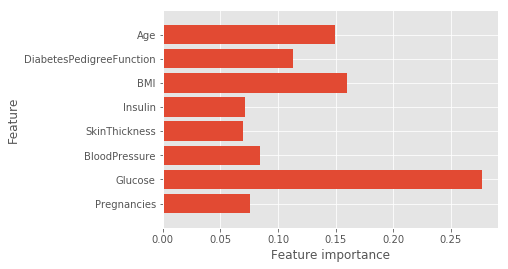

In [70]:
plot_feature_importances(model, train_cols)

In [71]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                               max_depth=8, max_features='auto', max_leaf_nodes=None,
                               min_impurity_split=1e-07, min_samples_leaf=1,
                               min_samples_split=2, min_weight_fraction_leaf=0.0,
                               n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
                               verbose=0, warm_start=False)
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)
print()
print_feature_importances(model, train_cols)

training:
accuracy:  0.97859922179
recall:    0.971021448431
precision: 0.982447069991
f1 score:  0.976334679698
confusion matrix:
 [[331   1]
 [ 10 172]]

validation:
accuracy:  0.755905511811
recall:    0.724667774086
precision: 0.72731092437
f1 score:  0.725931082492
confusion matrix:
 [[138  30]
 [ 32  54]]

Feature Importances
Glucose                                            0.3050416161989415
BMI                                                0.16390679907440886
Age                                                0.1526472409791853
DiabetesPedigreeFunction                           0.10057380831880386
BloodPressure                                      0.07214476152386994
Insulin                                            0.07129432918990306
Pregnancies                                        0.06809720944667971
SkinThickness                                      0.06629423526820738


In [72]:
model = DecisionTreeClassifier(max_depth=4, random_state=0)
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)
print()
print_feature_importances(model, train_cols)

training:
accuracy:  0.817120622568
recall:    0.814990732159
precision: 0.799977934687
f1 score:  0.805428479381
confusion matrix:
 [[273  59]
 [ 35 147]]

validation:
accuracy:  0.724409448819
recall:    0.71788482835
precision: 0.701794871795
f1 score:  0.705726580602
confusion matrix:
 [[124  44]
 [ 26  60]]

Feature Importances
Glucose                                            0.5952228573433964
BMI                                                0.19689619280048848
Age                                                0.1586471003002325
Insulin                                            0.02394004840922805
SkinThickness                                      0.015038484515635012
DiabetesPedigreeFunction                           0.010255316631019631
Pregnancies                                        0.0
BloodPressure                                      0.0


In [73]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                               max_depth=8, max_features='auto', max_leaf_nodes=None,
                               min_impurity_split=1e-07, min_samples_leaf=1,
                               min_samples_split=2, min_weight_fraction_leaf=0.0,
                               n_estimators=2000, n_jobs=1, oob_score=False, random_state=0,
                               verbose=0, warm_start=False)
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)
print()
print_feature_importances(model, train_cols)

training:
accuracy:  0.97859922179
recall:    0.971021448431
precision: 0.982447069991
f1 score:  0.976334679698
confusion matrix:
 [[331   1]
 [ 10 172]]

validation:
accuracy:  0.748031496063
recall:    0.715877630122
precision: 0.718417366947
f1 score:  0.717090149669
confusion matrix:
 [[137  31]
 [ 33  53]]

Feature Importances
Glucose                                            0.305580126521493
BMI                                                0.1618454569047287
Age                                                0.1522596680943952
DiabetesPedigreeFunction                           0.09998665540330204
Insulin                                            0.0726922381974857
BloodPressure                                      0.07250545473876177
Pregnancies                                        0.0690918692033182
SkinThickness                                      0.06603853093651527


In [74]:
model = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=800, presort='auto', random_state=0,
              subsample=1.0,verbose=0, warm_start=False)

model.fit(X_train, y_train)
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)
print()
print_feature_importances(model, train_cols)

training:
accuracy:  1.0
recall:    1.0
precision: 1.0
f1 score:  1.0
confusion matrix:
 [[332   0]
 [  0 182]]

validation:
accuracy:  0.712598425197
recall:    0.689091915836
precision: 0.682461764509
f1 score:  0.685147136235
confusion matrix:
 [[128  40]
 [ 33  53]]

Feature Importances
Glucose                                            0.08116974868537648
DiabetesPedigreeFunction                           0.08038963158906254
BMI                                                0.060453290944514924
Age                                                0.046177258915746526
BloodPressure                                      0.03240440393087284
Pregnancies                                        0.03185184872451583
Insulin                                            0.02705434823398697
SkinThickness                                      0.025499468975923992


In [145]:
params = {'max_depth':9, 'subsample':0.5, 'learning_rate':0.01, 'min_samples_leaf':1, 'random_state':0}
model = GradientBoostingClassifier(n_estimators=300, **params)
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)
print()
print_feature_importances(model, train_cols)

training:
accuracy:  1.0
recall:    1.0
precision: 1.0
f1 score:  1.0
confusion matrix:
 [[332   0]
 [  0 182]]

validation:
accuracy:  0.755905511811
recall:    0.724667774086
precision: 0.72731092437
f1 score:  0.725931082492
confusion matrix:
 [[138  30]
 [ 32  54]]

Feature Importances
Glucose                                            0.2570514354198549
BMI                                                0.15903609097374719
DiabetesPedigreeFunction                           0.15419689750403068
Age                                                0.14193386635038993
BloodPressure                                      0.08174540615679161
Pregnancies                                        0.07830147623473223
Insulin                                            0.06640263711221216
SkinThickness                                      0.06133219024824129


In [146]:
oof_gb = cv_analysis(model, Xs, y, 5)

Fold: 1
training
accuracy:  1.0
recall:    1.0
precision: 1.0
f1 score:  1.0
confusion matrix:
 [[400   0]
 [  0 214]]

validation:
accuracy:  0.753246753247
recall:    0.720555555556
precision: 0.729038461538
f1 score:  0.724170437406
confusion matrix:
 [[83 17]
 [21 33]]
Fold: 2
training
accuracy:  1.0
recall:    1.0
precision: 1.0
f1 score:  1.0
confusion matrix:
 [[410   0]
 [  0 204]]

validation:
accuracy:  0.720779220779
recall:    0.7046875
precision: 0.713239283776
f1 score:  0.707340787555
confusion matrix:
 [[72 18]
 [25 39]]
Fold: 3
training
accuracy:  1.0
recall:    1.0
precision: 1.0
f1 score:  1.0
confusion matrix:
 [[403   0]
 [  0 211]]

validation:
accuracy:  0.772727272727
recall:    0.725538071984
precision: 0.773464912281
f1 score:  0.73664924024
confusion matrix:
 [[88  9]
 [26 31]]
Fold: 4
training
accuracy:  1.0
recall:    1.0
precision: 1.0
f1 score:  1.0
confusion matrix:
 [[386   0]
 [  0 229]]

validation:
accuracy:  0.816993464052
recall:    0.767543859649


In [76]:
model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                           learning_rate=1.0, n_estimators=100, random_state=0)
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)
print()
print_feature_importances(model, train_cols)

training:
accuracy:  0.894941634241
recall:    0.875231696015
precision: 0.892483728016
f1 score:  0.882707910751
confusion matrix:
 [[313  19]
 [ 35 147]]

validation:
accuracy:  0.732283464567
recall:    0.701135105205
precision: 0.701135105205
f1 score:  0.701135105205
confusion matrix:
 [[134  34]
 [ 34  52]]

Feature Importances
Glucose                                            0.17
BMI                                                0.17
Age                                                0.16
DiabetesPedigreeFunction                           0.15
Insulin                                            0.13
BloodPressure                                      0.1
SkinThickness                                      0.09
Pregnancies                                        0.03


In [169]:
report_loss_scores(Y, oof_rf)

the loss:  0.48684436669
accuracy:  0.7734375
recall:    0.735104477612
precision: 0.753345342254
f1 score:  0.742023166023
confusion matrix:
 [[431  69]
 [105 163]]


In [170]:
report_loss_scores(Y, oof_gb)

the loss:  0.508228759273
accuracy:  0.759114583333
recall:    0.720641791045
precision: 0.736046465211
f1 score:  0.726558365201
confusion matrix:
 [[424  76]
 [109 159]]


### xgboost

In [111]:
dart_params = {'booster': 'dart',
               'max_depth': 10,
               'eta': 0.1,
               'objective': 'binary:logistic',
               'silent': True,
               'sample_type': 'uniform',
               'normalize_type': 'tree',
               'gamma': 12.8,
               'rate_drop': 0.1,
               'skip_drop': 0.5}


In [120]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(dart_params, d_train, 2000, watchlist, early_stopping_rounds=50, verbose_eval=100)

[0]	train-error:0.196498	valid-error:0.275591
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 50 rounds.
Stopping. Best iteration:
[6]	train-error:0.178988	valid-error:0.240157



In [121]:
print('train')
preds = bst.predict(xgb.DMatrix(X_train))
bpreds = np.array([ 1 if x > 0.5 else 0 for x in preds])
report_scores(y_train, bpreds)
print()
print('validation')
preds = bst.predict(xgb.DMatrix(X_test))
bpreds = np.array([ 1 if x > 0.5 else 0 for x in preds])
report_scores(y_test, bpreds)

train
accuracy:  0.789883268482
recall:    0.731844962267
precision: 0.796298646362
f1 score:  0.746811887691
confusion matrix:
 [[309  23]
 [ 85  97]]

validation
accuracy:  0.759842519685
recall:    0.699266334441
precision: 0.739258705227
f1 score:  0.710343796153
confusion matrix:
 [[149  19]
 [ 42  44]]


In [122]:
print('XGB features')
print('============')
for f,v in sorted(bst.get_fscore().items(), key=lambda x: (-x[1],x[0])):
    i = int(f.replace('f',''))
    print('{:<40} {:<50}'.format(train_cols[i],v))


XGB features
Glucose                                  33                                                
BMI                                      16                                                
Age                                      13                                                
Pregnancies                              1                                                 


In [112]:
params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.02
params["subsample"] = 0.7
params["min_child_weight"] = 1
params["colsample_bytree"] = 0.7
params["max_depth"] = 10
params["silent"] = 1
params["seed"] = 8128
params["lambda"] = 12.8


In [114]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 2000, watchlist, early_stopping_rounds=50, verbose_eval=100)


[0]	train-logloss:0.688526	valid-logloss:0.689914
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.447588	valid-logloss:0.530658
[200]	train-logloss:0.367984	valid-logloss:0.506643
[300]	train-logloss:0.321193	valid-logloss:0.504079
Stopping. Best iteration:
[291]	train-logloss:0.325068	valid-logloss:0.503863



In [119]:
print('train')
preds = bst.predict(xgb.DMatrix(X_train))
bpreds = np.array([ 1 if x > 0.5 else 0 for x in preds])
report_scores(y_train, bpreds)
print()
print('validation')
preds = bst.predict(xgb.DMatrix(X_test))
bpreds = np.array([ 1 if x > 0.5 else 0 for x in preds])
report_scores(y_test, bpreds)

train
accuracy:  0.906614785992
recall:    0.886750297895
precision: 0.90712543554
f1 score:  0.895445222315
confusion matrix:
 [[317  15]
 [ 33 149]]

validation
accuracy:  0.751968503937
recall:    0.72169158361
precision: 0.722972502611
f1 score:  0.722317663595
confusion matrix:
 [[137  31]
 [ 32  54]]


In [116]:
print('XGB features')
print('============')
for f,v in sorted(bst.get_fscore().items(), key=lambda x: (-x[1],x[0])):
    i = int(f.replace('f',''))
    print('{:<40} {:<50}'.format(train_cols[i],v))


XGB features
DiabetesPedigreeFunction                 1091                                              
Glucose                                  939                                               
BMI                                      938                                               
Age                                      891                                               
BloodPressure                            642                                               
Pregnancies                              549                                               
Insulin                                  490                                               
SkinThickness                            472                                               


In [185]:
def cv_xgb_analysis(params, X, y, n=5):
    cv = KFold(n_splits=n)
    i=1
    f1s = []
    oof_predictions = np.zeros((X.shape[0], 2))
    for train_index, test_index in cv.split(X):
        print('Fold:', i)
        Xtrain, Xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        d_train = xgb.DMatrix(Xtrain, label=ytrain)
        d_valid = xgb.DMatrix(Xtest, label=ytest)
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        bst = xgb.train(params, d_train, 2000, watchlist, early_stopping_rounds=50, verbose_eval=100)
        print('training')
        train_preds = bst.predict(xgb.DMatrix(Xtrain))
        train_bpreds = np.array([ 1 if x > 0.5 else 0 for x in train_preds])
        report_scores(ytrain, train_bpreds)
        print('\nvalidation:')
        val_preds = bst.predict(xgb.DMatrix(Xtest))
        val_bpreds = np.array([ 1 if x > 0.5 else 0 for x in val_preds])
        report_scores(ytest, val_bpreds)
       
        f1 = f1_score(ytest, val_bpreds, average='macro')
        f1s.append(f1)
        probs = bst.predict(xgb.DMatrix(Xtest))
        Probs = np.zeros((len(probs),2))
        Probs[:,1] = probs
        Probs[:,0] = 1-probs
        oof_predictions[test_index] = Probs
        i+=1
    print('\nMean F1:', sum(f1s)/len(f1s))
    return oof_predictions

In [186]:
oof_xgb = cv_xgb_analysis(params, X, y, 5)

Fold: 1
[0]	train-rmse:0.497023	valid-rmse:0.497917
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[100]	train-rmse:0.298277	valid-rmse:0.417784
[200]	train-rmse:0.212354	valid-rmse:0.412064
Stopping. Best iteration:
[178]	train-rmse:0.226442	valid-rmse:0.410708

training
accuracy:  0.995114006515
recall:    0.992990654206
precision: 0.996277915633
f1 score:  0.994602593217
confusion matrix:
 [[400   0]
 [  3 211]]

validation:
accuracy:  0.753246753247
recall:    0.724814814815
precision: 0.728883861237
f1 score:  0.726695311041
confusion matrix:
 [[82 18]
 [20 34]]
Fold: 2
[0]	train-rmse:0.497014	valid-rmse:0.498846
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[100]	train-rmse:0.294866	valid-rmse:0.438756
Stopping. Best iteration:
[146]	train-rmse:0.247837	valid-rmse:0.437163

training
acc

In [187]:
report_loss_scores(Y, oof_xgb)

the loss:  0.493800183643
accuracy:  0.752604166667
recall:    0.721701492537
precision: 0.72754986366
f1 score:  0.724319299916
confusion matrix:
 [[412  88]
 [102 166]]


## SVMs

In [77]:
model = svm.SVC(kernel='linear')

model.fit(X_train, y_train)
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)


training:
accuracy:  0.77626459144
recall:    0.726267708195
precision: 0.767213915763
f1 score:  0.73773997613
confusion matrix:
 [[298  34]
 [ 81 101]]

validation:
accuracy:  0.736220472441
recall:    0.68992248062
precision: 0.704394785847
f1 score:  0.695383679095
confusion matrix:
 [[140  28]
 [ 39  47]]


In [78]:
model = svm.SVC(C=1000)

model.fit(X_train, y_train)
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)

training:
accuracy:  0.813229571984
recall:    0.782189196346
precision: 0.801041666667
f1 score:  0.789678277326
confusion matrix:
 [[295  37]
 [ 59 123]]

validation:
accuracy:  0.736220472441
recall:    0.698435769657
precision: 0.704595732534
f1 score:  0.701160728397
confusion matrix:
 [[137  31]
 [ 36  50]]


In [79]:
model = svm.SVC(kernel='rbf')

model.fit(X_train, y_train)
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)

training:
accuracy:  0.77626459144
recall:    0.71882033629
precision: 0.774925664858
f1 score:  0.73194567263
confusion matrix:
 [[304  28]
 [ 87  95]]

validation:
accuracy:  0.759842519685
recall:    0.704941860465
precision: 0.736331710432
f1 score:  0.714738101813
confusion matrix:
 [[147  21]
 [ 40  46]]


In [80]:
model = svm.SVC(kernel='rbf', C=10, gamma=0.1)

model.fit(X_train, y_train)
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)

training:
accuracy:  0.784046692607
recall:    0.736015490534
precision: 0.776113767934
f1 score:  0.747739542205
confusion matrix:
 [[299  33]
 [ 78 104]]

validation:
accuracy:  0.759842519685
recall:    0.716292912514
precision: 0.732774674115
f1 score:  0.722662752609
confusion matrix:
 [[143  25]
 [ 36  50]]


### Check a couple parameters with gridsearch

In [82]:
param_grid = [{'C': [.01, .1, 1, 10, 100], 'kernel': ['linear']}]
model = svm.SVC(kernel="linear")
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid.fit(Xs, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [83]:
print("Best score: %0.2f%%" % (100*grid.best_score_))
print("Best estimator for parameter C: %f" % (grid.best_estimator_.C))

Best score: 76.69%
Best estimator for parameter C: 1.000000


In [84]:
param_grid = [{'C': [.01, .1, 1, 10, 100], 'kernel': ['rbf']}]
model = svm.SVC(kernel='rbf')
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid.fit(Xs, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [85]:
print("Best score: %0.2f%%" % (100*grid.best_score_))
print("Best estimator for parameter C: %f" % (grid.best_estimator_.C))

Best score: 77.08%
Best estimator for parameter C: 10.000000


In [152]:
model = svm.SVC(kernel='linear', C=1, probability=True)
oof_svm = cv_analysis(model, Xs, y, 5)

Fold: 1
training
accuracy:  0.775244299674
recall:    0.719941588785
precision: 0.765767927724
f1 score:  0.73226744186
confusion matrix:
 [[361  39]
 [ 99 115]]

validation:
accuracy:  0.753246753247
recall:    0.695
precision: 0.73888384755
f1 score:  0.705515297907
confusion matrix:
 [[89 11]
 [27 27]]
Fold: 2
training
accuracy:  0.781758957655
recall:    0.724521759923
precision: 0.762834509014
f1 score:  0.736699948797
confusion matrix:
 [[367  43]
 [ 91 113]]

validation:
accuracy:  0.707792207792
recall:    0.680034722222
precision: 0.706204016703
f1 score:  0.683084099328
confusion matrix:
 [[76 14]
 [31 33]]
Fold: 3
training
accuracy:  0.773615635179
recall:    0.713517105124
precision: 0.763252522909
f1 score:  0.726429700196
confusion matrix:
 [[365  38]
 [101 110]]

validation:
accuracy:  0.785714285714
recall:    0.728612769036
precision: 0.809803921569
f1 score:  0.742644452322
confusion matrix:
 [[92  5]
 [28 29]]
Fold: 4
training
accuracy:  0.751219512195
recall:    0.7

In [151]:
model = svm.SVC(kernel='rbf', C=10, probability=True)
oof_svm_rbf = cv_analysis(model, Xs, y, 5)

Fold: 1
training
accuracy:  0.775244299674
recall:    0.726460280374
precision: 0.760663188468
f1 score:  0.737053128103
confusion matrix:
 [[355  45]
 [ 93 121]]

validation:
accuracy:  0.766233766234
recall:    0.713518518519
precision: 0.752850877193
f1 score:  0.724398488765
confusion matrix:
 [[89 11]
 [25 29]]
Fold: 2
training
accuracy:  0.78664495114
recall:    0.729411764706
precision: 0.769702719798
f1 score:  0.742174753423
confusion matrix:
 [[369  41]
 [ 90 114]]

validation:
accuracy:  0.733766233766
recall:    0.706770833333
precision: 0.73682640684
f1 score:  0.71125440161
confusion matrix:
 [[78 12]
 [29 35]]
Fold: 3
training
accuracy:  0.785016286645
recall:    0.732362729764
precision: 0.773114935379
f1 score:  0.744698544699
confusion matrix:
 [[363  40]
 [ 92 119]]

validation:
accuracy:  0.779220779221
recall:    0.730692711159
precision: 0.784392419175
f1 score:  0.742727987421
confusion matrix:
 [[89  8]
 [26 31]]
Fold: 4
training
accuracy:  0.759349593496
recall

In [189]:
report_loss_scores(Y, oof_svm)

the loss:  0.476542187517
accuracy:  0.764322916667
recall:    0.710791044776
precision: 0.749454654644
f1 score:  0.721551290706
confusion matrix:
 [[444  56]
 [125 143]]


In [188]:
report_loss_scores(Y, oof_svm_rbf)

the loss:  0.471505332407
accuracy:  0.7734375
recall:    0.721253731343
precision: 0.760985915493
f1 score:  0.732641889945
confusion matrix:
 [[447  53]
 [121 147]]


## Neural network models

Finally time for some neural networks!

In [86]:
from sklearn.neural_network import MLPClassifier

In [87]:
model= MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10]).fit(X_train, y_train)
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)

training:
accuracy:  0.803501945525
recall:    0.770935389911
precision: 0.790034546904
f1 score:  0.778398152535
confusion matrix:
 [[293  39]
 [ 62 120]]

validation:
accuracy:  0.751968503937
recall:    0.718853820598
precision: 0.722785880364
f1 score:  0.720689113473
confusion matrix:
 [[138  30]
 [ 33  53]]


In [192]:
from keras.optimizers import Adam, Nadam

In [193]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.00001)
nadam = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, schedule_decay=0.004)

In [194]:
def fnn(input_features, num_classes, relu_layers, drop):
    inputs = Input(shape=(input_features,))
    
    x = Dense(16, activation='relu', kernel_initializer='lecun_normal',bias_initializer='zeros',)(inputs)
    for i in range(0, relu_layers):
        x = Dense(32,activation='relu', kernel_initializer='lecun_normal',bias_initializer='zeros')(x)
        
    x = Dropout(drop)(x)
    predictions = Dense(num_classes, activation='softmax',kernel_initializer='lecun_normal',
                        bias_initializer='zeros')(x)
    
    model = Model(inputs=inputs, outputs=predictions)
    return model

In [195]:
def snn(input_features, num_classes, selu_layers, alpha_drop):
    inputs = Input(shape=(input_features,))
    
    x = Dense(16, activation='selu', kernel_initializer='lecun_normal',bias_initializer='zeros',)(inputs)
    for i in range(0, selu_layers):
        x = Dense(32,activation='selu', kernel_initializer='lecun_normal',bias_initializer='zeros')(x)
        
    x = AlphaDropout(alpha_drop)(x)
    predictions = Dense(num_classes, activation='softmax',kernel_initializer='lecun_normal',
                        bias_initializer='zeros')(x)
    
    model = Model(inputs=inputs, outputs=predictions)
    return model

In [196]:
batch_size = 32
epochs = 100

In [197]:
mname = 'diabetes_best_fnn.h5'
check = keras.callbacks.ModelCheckpoint(mname, monitor='val_loss', verbose=0,
                                        save_best_only=True, save_weights_only=False,
                                        mode='auto', period=1)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.00001)

In [198]:
model = fnn(8, 2, 10, 0.25)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
__________

In [199]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.00001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=adam,
              metrics=['accuracy'])

In [200]:
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test),
          callbacks=[check])

In [201]:
model = load_model(mname)

train_predictions = np.argmax(model.predict(X_train),axis=1)
val_predictions = np.argmax(model.predict(X_test), axis=1)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)

training:
accuracy:  0.809338521401
recall:    0.7754534622
precision: 0.798023205844
f1 score:  0.784015093045
confusion matrix:
 [[296  36]
 [ 62 120]]

validation:
accuracy:  0.751968503937
recall:    0.713178294574
precision: 0.722784810127
f1 score:  0.717254174397
confusion matrix:
 [[140  28]
 [ 35  51]]


### SNNs

In [202]:
mname = 'diabetes_best_snn.h5'
check = keras.callbacks.ModelCheckpoint(mname, monitor='val_loss', verbose=0,
                                        save_best_only=True, save_weights_only=False,
                                        mode='auto', period=1)


In [203]:
model = snn(8, 2, 20, 0.1)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_14 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
__________

In [204]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.00001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=adam,
              metrics=['accuracy'])

In [205]:
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[check])

Train on 514 samples, validate on 254 samples
Epoch 1/100
514/514 [==============================] - 2s - loss: 0.6540 - acc: 0.6479 - val_loss: 0.8411 - val_acc: 0.6614
Epoch 2/100
514/514 [==============================] - 0s - loss: 0.6351 - acc: 0.6673 - val_loss: 0.5986 - val_acc: 0.6654
Epoch 3/100
514/514 [==============================] - 0s - loss: 0.5785 - acc: 0.7043 - val_loss: 0.5772 - val_acc: 0.6654
Epoch 4/100
514/514 [==============================] - 0s - loss: 0.5984 - acc: 0.6693 - val_loss: 0.5559 - val_acc: 0.7126
Epoch 5/100
514/514 [==============================] - 0s - loss: 0.5220 - acc: 0.7296 - val_loss: 0.5497 - val_acc: 0.7087
Epoch 6/100
514/514 [==============================] - 0s - loss: 0.4938 - acc: 0.7588 - val_loss: 0.5914 - val_acc: 0.6850
Epoch 7/100
514/514 [==============================] - 0s - loss: 0.5632 - acc: 0.7276 - val_loss: 0.5495 - val_acc: 0.7283
Epoch 8/100
514/514 [==============================] - 0s - loss: 0.4910 - acc: 0.7685

In [206]:
model = load_model(mname)

In [207]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.509020742
Test accuracy: 0.736220474318


In [208]:
train_predictions = np.argmax(model.predict(X_train),axis=1)
val_predictions = np.argmax(model.predict(X_test), axis=1)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)

training:
accuracy:  0.785992217899
recall:    0.751175029789
precision: 0.769822927037
f1 score:  0.758293433653
confusion matrix:
 [[289  43]
 [ 67 115]]

validation:
accuracy:  0.736220472441
recall:    0.701273532669
precision: 0.704889734376
f1 score:  0.702955088932
confusion matrix:
 [[136  32]
 [ 35  51]]


In [209]:
#lets try a few less layers
model = snn(8, 2, 10, 0.1)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_36 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_37 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_38 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_39 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_40 (Dense)             (None, 32)                1056      
__________

In [210]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.00001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=adam,
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[check])

Train on 514 samples, validate on 254 samples
Epoch 1/100
514/514 [==============================] - 1s - loss: 0.7107 - acc: 0.5837 - val_loss: 0.6499 - val_acc: 0.6181
Epoch 2/100
514/514 [==============================] - 0s - loss: 0.6256 - acc: 0.6459 - val_loss: 0.6240 - val_acc: 0.6457
Epoch 3/100
514/514 [==============================] - 0s - loss: 0.5824 - acc: 0.6887 - val_loss: 0.5701 - val_acc: 0.7047
Epoch 4/100
514/514 [==============================] - 0s - loss: 0.5494 - acc: 0.7296 - val_loss: 0.5400 - val_acc: 0.7402
Epoch 5/100
514/514 [==============================] - 0s - loss: 0.5532 - acc: 0.7179 - val_loss: 0.5447 - val_acc: 0.7283
Epoch 6/100
514/514 [==============================] - 0s - loss: 0.5082 - acc: 0.7412 - val_loss: 0.5686 - val_acc: 0.7520
Epoch 7/100
514/514 [==============================] - 0s - loss: 0.4966 - acc: 0.7432 - val_loss: 0.6003 - val_acc: 0.6693
Epoch 8/100
514/514 [==============================] - 0s - loss: 0.5801 - acc: 0.6790

In [211]:
model = load_model(mname)

train_predictions = np.argmax(model.predict(X_train),axis=1)
val_predictions = np.argmax(model.predict(X_test), axis=1)
print('training:')
report_scores(y_train, train_predictions)
print('\nvalidation:')
report_scores(y_test, val_predictions)

training:
accuracy:  0.785992217899
recall:    0.751175029789
precision: 0.769822927037
f1 score:  0.758293433653
confusion matrix:
 [[289  43]
 [ 67 115]]

validation:
accuracy:  0.736220472441
recall:    0.701273532669
precision: 0.704889734376
f1 score:  0.702955088932
confusion matrix:
 [[136  32]
 [ 35  51]]


In [216]:
def cv_nn_analysis(model, X, y, n=5):
    mname = 'diabetes_best_nn_cv.h5'
    check = keras.callbacks.ModelCheckpoint(mname, monitor='val_loss', verbose=0,
                                        save_best_only=True, save_weights_only=False,
                                        mode='auto', period=1)
    cv = KFold(n_splits=n)
    i=1
    f1s = []
    oof_predictions = np.zeros((X.shape[0], 2))
    for train_index, test_index in cv.split(X):
        print('Fold:', i)
        Xtrain, Xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        Ytrain = to_categorical(ytrain)
        Ytest = to_categorical(ytest)
        adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.00001)
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=adam, metrics=['accuracy'])
        model.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs,
                  verbose=1, validation_data=(Xtest, Ytest), callbacks=[check])
       
        model = load_model(mname)
        train_predictions = np.argmax(model.predict(Xtrain), axis=1)
        val_predictions = np.argmax(model.predict(Xtest), axis=1)
        print('training')
        report_scores(ytrain, train_predictions)
        print('\nvalidation:')
        report_scores(ytest, val_predictions)
        f1 = f1_score(ytest, val_predictions, average='macro')
        f1s.append(f1)
        probs = model.predict(Xtest)
        oof_predictions[test_index] = probs
        i+=1
    print('\nMean F1:', sum(f1s)/len(f1s))
    return oof_predictions

In [217]:
model = snn(8, 2, 10, 0.1)
oof_snn = cv_nn_analysis(model, Xs, y, 5)

Fold: 1
Train on 614 samples, validate on 154 samples
Epoch 1/100
614/614 [==============================] - 2s - loss: 0.6461 - acc: 0.6466 - val_loss: 0.6301 - val_acc: 0.5779
Epoch 2/100
614/614 [==============================] - 0s - loss: 0.5563 - acc: 0.6906 - val_loss: 0.5538 - val_acc: 0.7468
Epoch 3/100
614/614 [==============================] - 0s - loss: 0.5420 - acc: 0.7134 - val_loss: 0.5009 - val_acc: 0.7532
Epoch 4/100
614/614 [==============================] - 0s - loss: 0.5282 - acc: 0.7280 - val_loss: 0.5068 - val_acc: 0.7532
Epoch 5/100
614/614 [==============================] - 0s - loss: 0.4809 - acc: 0.7704 - val_loss: 0.5200 - val_acc: 0.7468
Epoch 6/100
614/614 [==============================] - 0s - loss: 0.4799 - acc: 0.7655 - val_loss: 0.5371 - val_acc: 0.7662
Epoch 7/100
614/614 [==============================] - 0s - loss: 0.5113 - acc: 0.7524 - val_loss: 0.5141 - val_acc: 0.6948
Epoch 8/100
614/614 [==============================] - 0s - loss: 0.4765 - acc

614/614 [==============================] - 0s - loss: 0.4188 - acc: 0.8127 - val_loss: 0.5829 - val_acc: 0.7143
Epoch 29/100
614/614 [==============================] - 0s - loss: 0.4123 - acc: 0.8013 - val_loss: 0.6748 - val_acc: 0.7273
Epoch 30/100
614/614 [==============================] - 0s - loss: 0.4367 - acc: 0.7964 - val_loss: 0.6328 - val_acc: 0.7208
Epoch 31/100
614/614 [==============================] - 0s - loss: 0.4180 - acc: 0.7948 - val_loss: 0.6210 - val_acc: 0.7208
Epoch 32/100
614/614 [==============================] - 0s - loss: 0.4099 - acc: 0.7980 - val_loss: 0.6061 - val_acc: 0.6883
Epoch 33/100
614/614 [==============================] - 0s - loss: 0.4062 - acc: 0.8160 - val_loss: 0.7288 - val_acc: 0.7273
Epoch 34/100
614/614 [==============================] - 0s - loss: 0.4171 - acc: 0.8013 - val_loss: 0.6037 - val_acc: 0.7013
Epoch 35/100
614/614 [==============================] - 0s - loss: 0.4025 - acc: 0.8143 - val_loss: 0.6485 - val_acc: 0.7013
Epoch 36/100


614/614 [==============================] - 0s - loss: 0.4239 - acc: 0.7801 - val_loss: 0.5348 - val_acc: 0.7922
Epoch 56/100
614/614 [==============================] - 0s - loss: 0.4357 - acc: 0.7834 - val_loss: 0.4842 - val_acc: 0.7792
Epoch 57/100
614/614 [==============================] - 0s - loss: 0.4225 - acc: 0.7883 - val_loss: 0.4528 - val_acc: 0.7792
Epoch 58/100
614/614 [==============================] - 0s - loss: 0.4177 - acc: 0.7899 - val_loss: 0.5022 - val_acc: 0.8052
Epoch 59/100
614/614 [==============================] - 0s - loss: 0.4237 - acc: 0.7932 - val_loss: 0.4954 - val_acc: 0.7922
Epoch 60/100
614/614 [==============================] - 0s - loss: 0.4295 - acc: 0.7785 - val_loss: 0.4358 - val_acc: 0.7987
Epoch 61/100
614/614 [==============================] - 0s - loss: 0.4307 - acc: 0.7948 - val_loss: 0.4451 - val_acc: 0.7792
Epoch 62/100
614/614 [==============================] - 0s - loss: 0.4180 - acc: 0.7769 - val_loss: 0.4785 - val_acc: 0.7922
Epoch 63/100


615/615 [==============================] - 0s - loss: 0.3880 - acc: 0.8065 - val_loss: 0.4781 - val_acc: 0.7908
Epoch 83/100
615/615 [==============================] - 0s - loss: 0.3666 - acc: 0.7984 - val_loss: 0.4466 - val_acc: 0.7974
Epoch 84/100
615/615 [==============================] - 0s - loss: 0.3634 - acc: 0.8098 - val_loss: 0.4562 - val_acc: 0.7974
Epoch 85/100
615/615 [==============================] - 0s - loss: 0.3488 - acc: 0.8130 - val_loss: 0.5662 - val_acc: 0.7778
Epoch 86/100
615/615 [==============================] - 0s - loss: 0.3691 - acc: 0.8260 - val_loss: 0.4792 - val_acc: 0.8105
Epoch 87/100
615/615 [==============================] - 0s - loss: 0.3745 - acc: 0.8146 - val_loss: 0.5193 - val_acc: 0.8105
Epoch 88/100
615/615 [==============================] - 0s - loss: 0.3361 - acc: 0.8358 - val_loss: 0.5349 - val_acc: 0.7974
Epoch 89/100
615/615 [==============================] - 0s - loss: 0.3427 - acc: 0.8341 - val_loss: 0.5050 - val_acc: 0.8039
Epoch 90/100


In [220]:
model = snn(8, 2, 20, 0.1)
oof_snn_20 = cv_nn_analysis(model, Xs, y, 5)

Fold: 1
Train on 614 samples, validate on 154 samples
Epoch 1/100
614/614 [==============================] - 6s - loss: 0.6996 - acc: 0.5961 - val_loss: 0.6302 - val_acc: 0.6494
Epoch 2/100
614/614 [==============================] - 0s - loss: 0.6558 - acc: 0.6156 - val_loss: 0.5968 - val_acc: 0.6494
Epoch 3/100
614/614 [==============================] - 0s - loss: 0.5856 - acc: 0.6987 - val_loss: 0.5872 - val_acc: 0.7208
Epoch 4/100
614/614 [==============================] - 0s - loss: 0.5136 - acc: 0.7410 - val_loss: 0.6209 - val_acc: 0.7273
Epoch 5/100
614/614 [==============================] - 0s - loss: 0.5150 - acc: 0.7410 - val_loss: 0.6679 - val_acc: 0.6688
Epoch 6/100
614/614 [==============================] - 0s - loss: 0.4822 - acc: 0.7541 - val_loss: 0.5212 - val_acc: 0.7532
Epoch 7/100
614/614 [==============================] - 0s - loss: 0.4990 - acc: 0.7541 - val_loss: 0.5548 - val_acc: 0.7727
Epoch 8/100
614/614 [==============================] - 0s - loss: 0.4823 - acc

614/614 [==============================] - 0s - loss: 0.4156 - acc: 0.7915 - val_loss: 0.5938 - val_acc: 0.6948
Epoch 29/100
614/614 [==============================] - 0s - loss: 0.4091 - acc: 0.7980 - val_loss: 0.5901 - val_acc: 0.7338
Epoch 30/100
614/614 [==============================] - 0s - loss: 0.4074 - acc: 0.8143 - val_loss: 0.5946 - val_acc: 0.7338
Epoch 31/100
614/614 [==============================] - 0s - loss: 0.3993 - acc: 0.8127 - val_loss: 0.5762 - val_acc: 0.7078
Epoch 32/100
614/614 [==============================] - 0s - loss: 0.4053 - acc: 0.8094 - val_loss: 0.5975 - val_acc: 0.7143
Epoch 33/100
614/614 [==============================] - 0s - loss: 0.4061 - acc: 0.8013 - val_loss: 0.6579 - val_acc: 0.6883
Epoch 34/100
614/614 [==============================] - 0s - loss: 0.4023 - acc: 0.8062 - val_loss: 0.7084 - val_acc: 0.6948
Epoch 35/100
614/614 [==============================] - 0s - loss: 0.4306 - acc: 0.7899 - val_loss: 0.5818 - val_acc: 0.7468
Epoch 36/100


614/614 [==============================] - 0s - loss: 0.4199 - acc: 0.7980 - val_loss: 0.5067 - val_acc: 0.7597
Epoch 56/100
614/614 [==============================] - 0s - loss: 0.4478 - acc: 0.7638 - val_loss: 0.5886 - val_acc: 0.7857
Epoch 57/100
614/614 [==============================] - 0s - loss: 0.4300 - acc: 0.7964 - val_loss: 0.5106 - val_acc: 0.78570.77
Epoch 58/100
614/614 [==============================] - 0s - loss: 0.4220 - acc: 0.8111 - val_loss: 0.5388 - val_acc: 0.7922
Epoch 59/100
614/614 [==============================] - 0s - loss: 0.4428 - acc: 0.7866 - val_loss: 0.5340 - val_acc: 0.7532
Epoch 60/100
614/614 [==============================] - 0s - loss: 0.4248 - acc: 0.7818 - val_loss: 0.5476 - val_acc: 0.7987
Epoch 61/100
614/614 [==============================] - 0s - loss: 0.4370 - acc: 0.7801 - val_loss: 0.5418 - val_acc: 0.7662
Epoch 62/100
614/614 [==============================] - 0s - loss: 0.4395 - acc: 0.7883 - val_loss: 0.5129 - val_acc: 0.7857
Epoch 63/

615/615 [==============================] - 0s - loss: 0.3696 - acc: 0.8260 - val_loss: 0.4249 - val_acc: 0.8235
Epoch 83/100
615/615 [==============================] - 0s - loss: 0.3765 - acc: 0.8260 - val_loss: 0.3983 - val_acc: 0.8170
Epoch 84/100
615/615 [==============================] - 0s - loss: 0.3904 - acc: 0.8146 - val_loss: 0.4259 - val_acc: 0.8039
Epoch 85/100
615/615 [==============================] - 0s - loss: 0.3739 - acc: 0.8163 - val_loss: 0.4396 - val_acc: 0.7908
Epoch 86/100
615/615 [==============================] - 0s - loss: 0.3859 - acc: 0.8065 - val_loss: 0.4555 - val_acc: 0.7908
Epoch 87/100
615/615 [==============================] - 0s - loss: 0.4988 - acc: 0.7512 - val_loss: 0.3866 - val_acc: 0.8366
Epoch 88/100
615/615 [==============================] - 0s - loss: 0.4835 - acc: 0.7837 - val_loss: 0.4206 - val_acc: 0.8039
Epoch 89/100
615/615 [==============================] - 0s - loss: 0.4470 - acc: 0.7610 - val_loss: 0.4225 - val_acc: 0.8301
Epoch 90/100


In [226]:
model = snn(8, 2, 30, 0.1)
oof_snn_30 = cv_nn_analysis(model, Xs, y, 5)

Fold: 1
Train on 614 samples, validate on 154 samples
Epoch 1/100
614/614 [==============================] - 292s - loss: 0.7199 - acc: 0.5521 - val_loss: 0.7370 - val_acc: 0.6494
Epoch 2/100
614/614 [==============================] - 0s - loss: 0.6207 - acc: 0.6726 - val_loss: 0.6033 - val_acc: 0.6494
Epoch 3/100
614/614 [==============================] - 0s - loss: 0.5933 - acc: 0.6710 - val_loss: 0.5577 - val_acc: 0.6948
Epoch 4/100
614/614 [==============================] - 0s - loss: 0.5599 - acc: 0.6840 - val_loss: 0.5761 - val_acc: 0.7273
Epoch 5/100
614/614 [==============================] - 0s - loss: 0.5455 - acc: 0.7068 - val_loss: 0.6033 - val_acc: 0.6558
Epoch 6/100
614/614 [==============================] - 0s - loss: 0.5799 - acc: 0.6775 - val_loss: 0.5294 - val_acc: 0.7013
Epoch 7/100
614/614 [==============================] - 0s - loss: 0.5535 - acc: 0.6906 - val_loss: 0.6377 - val_acc: 0.7208
Epoch 8/100
614/614 [==============================] - 0s - loss: 0.5374 - a

614/614 [==============================] - 0s - loss: 0.5141 - acc: 0.7834 - val_loss: 0.5893 - val_acc: 0.6948
Epoch 29/100
614/614 [==============================] - 0s - loss: 0.4721 - acc: 0.7850 - val_loss: 0.5821 - val_acc: 0.7208
Epoch 30/100
614/614 [==============================] - 0s - loss: 0.4767 - acc: 0.7818 - val_loss: 0.5658 - val_acc: 0.7078
Epoch 31/100
614/614 [==============================] - 0s - loss: 0.4620 - acc: 0.7948 - val_loss: 0.5644 - val_acc: 0.7208
Epoch 32/100
614/614 [==============================] - 0s - loss: 0.4428 - acc: 0.7948 - val_loss: 0.5544 - val_acc: 0.7208
Epoch 33/100
614/614 [==============================] - 0s - loss: 0.4491 - acc: 0.7980 - val_loss: 0.6159 - val_acc: 0.7013
Epoch 34/100
614/614 [==============================] - 0s - loss: 0.4583 - acc: 0.7866 - val_loss: 0.5898 - val_acc: 0.7338
Epoch 35/100
614/614 [==============================] - 0s - loss: 0.4317 - acc: 0.8062 - val_loss: 0.5309 - val_acc: 0.7338
Epoch 36/100


614/614 [==============================] - 0s - loss: 0.5917 - acc: 0.7280 - val_loss: 0.5829 - val_acc: 0.7273
Epoch 56/100
614/614 [==============================] - 0s - loss: 0.5573 - acc: 0.7541 - val_loss: 0.5671 - val_acc: 0.7338
Epoch 57/100
614/614 [==============================] - 0s - loss: 0.5733 - acc: 0.7476 - val_loss: 0.6675 - val_acc: 0.6558
Epoch 58/100
614/614 [==============================] - 0s - loss: 0.6349 - acc: 0.6678 - val_loss: 0.6545 - val_acc: 0.6429
Epoch 59/100
614/614 [==============================] - 0s - loss: 0.6521 - acc: 0.6612 - val_loss: 0.6537 - val_acc: 0.6429
Epoch 60/100
614/614 [==============================] - 0s - loss: 0.6394 - acc: 0.6612 - val_loss: 0.6552 - val_acc: 0.6429
Epoch 61/100
614/614 [==============================] - 0s - loss: 0.6433 - acc: 0.6612 - val_loss: 0.6590 - val_acc: 0.6429
Epoch 62/100
614/614 [==============================] - 0s - loss: 0.6423 - acc: 0.6612 - val_loss: 0.6586 - val_acc: 0.6429
Epoch 63/100


615/615 [==============================] - 0s - loss: 0.5300 - acc: 0.6862 - val_loss: 0.3662 - val_acc: 0.8235
Epoch 83/100
615/615 [==============================] - 0s - loss: 0.5644 - acc: 0.7236 - val_loss: 0.4221 - val_acc: 0.8497
Epoch 84/100
615/615 [==============================] - 0s - loss: 0.5434 - acc: 0.7463 - val_loss: 0.4297 - val_acc: 0.8170
Epoch 85/100
615/615 [==============================] - 0s - loss: 0.5356 - acc: 0.7317 - val_loss: 0.4518 - val_acc: 0.8105
Epoch 86/100
615/615 [==============================] - 0s - loss: 0.5991 - acc: 0.7317 - val_loss: 0.4897 - val_acc: 0.8301
Epoch 87/100
615/615 [==============================] - 0s - loss: 0.5493 - acc: 0.7577 - val_loss: 0.4724 - val_acc: 0.8105
Epoch 88/100
615/615 [==============================] - 0s - loss: 0.5539 - acc: 0.7593 - val_loss: 0.4482 - val_acc: 0.8170
Epoch 89/100
615/615 [==============================] - 0s - loss: 0.5216 - acc: 0.7431 - val_loss: 0.4146 - val_acc: 0.8235
Epoch 90/100


In [222]:
model = fnn(8, 2, 10, 0.25)
oof_fnn = cv_nn_analysis(model, Xs, y, 5)

Fold: 1
Train on 614 samples, validate on 154 samples
Epoch 1/100
614/614 [==============================] - 7s - loss: 0.6787 - acc: 0.6547 - val_loss: 0.6611 - val_acc: 0.6494
Epoch 2/100
614/614 [==============================] - 0s - loss: 0.6572 - acc: 0.6515 - val_loss: 0.6497 - val_acc: 0.6494
Epoch 3/100
614/614 [==============================] - 0s - loss: 0.6498 - acc: 0.6515 - val_loss: 0.6439 - val_acc: 0.6494
Epoch 4/100
614/614 [==============================] - 0s - loss: 0.6435 - acc: 0.6515 - val_loss: 0.6371 - val_acc: 0.6494
Epoch 5/100
614/614 [==============================] - 0s - loss: 0.6234 - acc: 0.6515 - val_loss: 0.6052 - val_acc: 0.6494
Epoch 6/100
614/614 [==============================] - 0s - loss: 0.5853 - acc: 0.6515 - val_loss: 0.5692 - val_acc: 0.6494
Epoch 7/100
614/614 [==============================] - 0s - loss: 0.5398 - acc: 0.6775 - val_loss: 0.5621 - val_acc: 0.7338
Epoch 8/100
614/614 [==============================] - 0s - loss: 0.5136 - acc

614/614 [==============================] - 0s - loss: 0.4007 - acc: 0.8176 - val_loss: 0.5733 - val_acc: 0.6948
Epoch 29/100
614/614 [==============================] - 0s - loss: 0.3761 - acc: 0.8192 - val_loss: 0.5857 - val_acc: 0.7078
Epoch 30/100
614/614 [==============================] - 0s - loss: 0.3541 - acc: 0.8322 - val_loss: 0.6470 - val_acc: 0.7013
Epoch 31/100
614/614 [==============================] - 0s - loss: 0.3654 - acc: 0.8322 - val_loss: 0.6036 - val_acc: 0.6948
Epoch 32/100
614/614 [==============================] - 0s - loss: 0.3499 - acc: 0.8469 - val_loss: 0.6142 - val_acc: 0.6948
Epoch 33/100
614/614 [==============================] - 0s - loss: 0.3511 - acc: 0.8502 - val_loss: 0.6662 - val_acc: 0.7013
Epoch 34/100
614/614 [==============================] - 0s - loss: 0.3565 - acc: 0.8322 - val_loss: 0.6094 - val_acc: 0.7078
Epoch 35/100
614/614 [==============================] - 0s - loss: 0.3462 - acc: 0.8518 - val_loss: 0.6307 - val_acc: 0.6883
Epoch 36/100


614/614 [==============================] - 0s - loss: 0.3587 - acc: 0.8160 - val_loss: 0.4386 - val_acc: 0.7987
Epoch 56/100
614/614 [==============================] - 0s - loss: 0.3878 - acc: 0.8176 - val_loss: 0.4194 - val_acc: 0.7987
Epoch 57/100
614/614 [==============================] - 0s - loss: 0.3733 - acc: 0.8192 - val_loss: 0.4189 - val_acc: 0.7922
Epoch 58/100
614/614 [==============================] - 0s - loss: 0.3749 - acc: 0.8176 - val_loss: 0.4215 - val_acc: 0.7857
Epoch 59/100
614/614 [==============================] - 0s - loss: 0.3836 - acc: 0.7997 - val_loss: 0.4325 - val_acc: 0.8052
Epoch 60/100
614/614 [==============================] - 0s - loss: 0.3853 - acc: 0.8127 - val_loss: 0.4246 - val_acc: 0.8052
Epoch 61/100
614/614 [==============================] - 0s - loss: 0.3620 - acc: 0.8257 - val_loss: 0.4373 - val_acc: 0.7922
Epoch 62/100
614/614 [==============================] - 0s - loss: 0.3695 - acc: 0.8111 - val_loss: 0.4807 - val_acc: 0.8052
Epoch 63/100


615/615 [==============================] - 0s - loss: 0.3425 - acc: 0.8358 - val_loss: 0.5104 - val_acc: 0.7974
Epoch 83/100
615/615 [==============================] - 0s - loss: 0.3067 - acc: 0.8585 - val_loss: 0.4919 - val_acc: 0.8105
Epoch 84/100
615/615 [==============================] - 0s - loss: 0.3138 - acc: 0.8520 - val_loss: 0.5290 - val_acc: 0.8170
Epoch 85/100
615/615 [==============================] - 0s - loss: 0.3242 - acc: 0.8439 - val_loss: 0.4605 - val_acc: 0.8170
Epoch 86/100
615/615 [==============================] - 0s - loss: 0.3243 - acc: 0.8407 - val_loss: 0.5010 - val_acc: 0.8105
Epoch 87/100
615/615 [==============================] - 0s - loss: 0.2975 - acc: 0.8667 - val_loss: 0.5177 - val_acc: 0.8235
Epoch 88/100
615/615 [==============================] - 0s - loss: 0.3154 - acc: 0.8472 - val_loss: 0.4883 - val_acc: 0.8235
Epoch 89/100
615/615 [==============================] - 0s - loss: 0.2841 - acc: 0.8537 - val_loss: 0.5454 - val_acc: 0.8039
Epoch 90/100


In [224]:
model = fnn(8, 2, 20, 0.25)
oof_fnn_20 = cv_nn_analysis(model, Xs, y, 5)

Fold: 1
Train on 614 samples, validate on 154 samples
Epoch 1/100
614/614 [==============================] - 12s - loss: 0.6830 - acc: 0.6482 - val_loss: 0.6688 - val_acc: 0.6494
Epoch 2/100
614/614 [==============================] - 0s - loss: 0.6590 - acc: 0.6515 - val_loss: 0.6484 - val_acc: 0.6494
Epoch 3/100
614/614 [==============================] - 0s - loss: 0.6506 - acc: 0.6515 - val_loss: 0.6472 - val_acc: 0.6494
Epoch 4/100
614/614 [==============================] - 0s - loss: 0.6528 - acc: 0.6515 - val_loss: 0.6466 - val_acc: 0.6494
Epoch 5/100
614/614 [==============================] - 0s - loss: 0.6356 - acc: 0.6515 - val_loss: 0.6192 - val_acc: 0.6494
Epoch 6/100
614/614 [==============================] - 0s - loss: 0.5746 - acc: 0.6515 - val_loss: 0.5599 - val_acc: 0.6494
Epoch 7/100
614/614 [==============================] - 0s - loss: 0.5332 - acc: 0.6515 - val_loss: 0.5410 - val_acc: 0.6494
Epoch 8/100
614/614 [==============================] - 0s - loss: 0.5134 - ac

614/614 [==============================] - 0s - loss: 0.4124 - acc: 0.8029 - val_loss: 0.6268 - val_acc: 0.7078
Epoch 29/100
614/614 [==============================] - 0s - loss: 0.3920 - acc: 0.8225 - val_loss: 0.5689 - val_acc: 0.7013
Epoch 30/100
614/614 [==============================] - 0s - loss: 0.3842 - acc: 0.8290 - val_loss: 0.6029 - val_acc: 0.6883
Epoch 31/100
614/614 [==============================] - 0s - loss: 0.3931 - acc: 0.8192 - val_loss: 0.5271 - val_acc: 0.6753
Epoch 32/100
614/614 [==============================] - 0s - loss: 0.3918 - acc: 0.8290 - val_loss: 0.6416 - val_acc: 0.6753
Epoch 33/100
614/614 [==============================] - 0s - loss: 0.3860 - acc: 0.8290 - val_loss: 0.6341 - val_acc: 0.6818
Epoch 34/100
614/614 [==============================] - 0s - loss: 0.3879 - acc: 0.8241 - val_loss: 0.6538 - val_acc: 0.7208
Epoch 35/100
614/614 [==============================] - 0s - loss: 0.3988 - acc: 0.8062 - val_loss: 0.6465 - val_acc: 0.7078
Epoch 36/100


614/614 [==============================] - 0s - loss: 0.3829 - acc: 0.8176 - val_loss: 0.4468 - val_acc: 0.7922
Epoch 56/100
614/614 [==============================] - 0s - loss: 0.4051 - acc: 0.8029 - val_loss: 0.4407 - val_acc: 0.7662
Epoch 57/100
614/614 [==============================] - 0s - loss: 0.3899 - acc: 0.8127 - val_loss: 0.4342 - val_acc: 0.7792
Epoch 58/100
614/614 [==============================] - 0s - loss: 0.4044 - acc: 0.8013 - val_loss: 0.4447 - val_acc: 0.7987
Epoch 59/100
614/614 [==============================] - 0s - loss: 0.4000 - acc: 0.8094 - val_loss: 0.4256 - val_acc: 0.7727
Epoch 60/100
614/614 [==============================] - 0s - loss: 0.3771 - acc: 0.8241 - val_loss: 0.4708 - val_acc: 0.7792
Epoch 61/100
614/614 [==============================] - 0s - loss: 0.3834 - acc: 0.8094 - val_loss: 0.4802 - val_acc: 0.7727
Epoch 62/100
614/614 [==============================] - 0s - loss: 0.3890 - acc: 0.8046 - val_loss: 0.4621 - val_acc: 0.7922
Epoch 63/100


615/615 [==============================] - 0s - loss: 0.3131 - acc: 0.8309 - val_loss: 0.4286 - val_acc: 0.8105
Epoch 83/100
615/615 [==============================] - 0s - loss: 0.3055 - acc: 0.8569 - val_loss: 0.4374 - val_acc: 0.8105
Epoch 84/100
615/615 [==============================] - 0s - loss: 0.3089 - acc: 0.8455 - val_loss: 0.4112 - val_acc: 0.8105
Epoch 85/100
615/615 [==============================] - 0s - loss: 0.2916 - acc: 0.8455 - val_loss: 0.4275 - val_acc: 0.7974
Epoch 86/100
615/615 [==============================] - 0s - loss: 0.2984 - acc: 0.8423 - val_loss: 0.4705 - val_acc: 0.8235
Epoch 87/100
615/615 [==============================] - 0s - loss: 0.2849 - acc: 0.8455 - val_loss: 0.4640 - val_acc: 0.8170
Epoch 88/100
615/615 [==============================] - 0s - loss: 0.3006 - acc: 0.8488 - val_loss: 0.5328 - val_acc: 0.7843
Epoch 89/100
615/615 [==============================] - 0s - loss: 0.3563 - acc: 0.8374 - val_loss: 0.3613 - val_acc: 0.7974
Epoch 90/100


In [223]:
report_loss_scores(Y, oof_fnn)

the loss:  0.426186095073
accuracy:  0.794270833333
recall:    0.745910447761
precision: 0.786399666249
f1 score:  0.758378998343
confusion matrix:
 [[453  47]
 [111 157]]


In [225]:
report_loss_scores(Y, oof_fnn_20)

the loss:  0.421697630951
accuracy:  0.779947916667
recall:    0.753089552239
precision: 0.758240879636
f1 score:  0.755467005793
confusion matrix:
 [[421  79]
 [ 90 178]]


In [219]:
report_loss_scores(Y, oof_snn)

the loss:  0.444152145275
accuracy:  0.78125
recall:    0.737641791045
precision: 0.765587989992
f1 score:  0.747160493827
confusion matrix:
 [[441  59]
 [109 159]]


In [221]:
report_loss_scores(Y, oof_snn_20)

the loss:  0.428059257819
accuracy:  0.805989583333
recall:    0.767895522388
precision: 0.793824432167
f1 score:  0.77745580991
confusion matrix:
 [[447  53]
 [ 96 172]]


In [227]:
report_loss_scores(Y, oof_snn_30)

the loss:  0.452133668273
accuracy:  0.765625
recall:    0.723044776119
precision: 0.745273109244
f1 score:  0.73086627418
confusion matrix:
 [[432  68]
 [112 156]]


## Model diversity comparison

In [230]:
from scipy.stats import ks_2samp
from sklearn.metrics import mutual_info_score
from scipy.stats import pearsonr

In [249]:
def calculate_diversity(a, b):
    for i in range(1):
        pr, p_pr = pearsonr(a[:,i], b[:,i])
        print('Pearson:', pr )
        ks, p_ks = ks_2samp(a[:,i], b[:,i])
        print('KS:     ', ks)
        print('MI:     ', mutual_info_score(a[:,i], b[:,i]))
    return

In [250]:
calculate_diversity(oof_lasso, oof_ridge)

Pearson: 0.999999873565
KS:      0.00390625
MI:      6.64378973315


In [251]:
calculate_diversity(oof_knn_5, oof_logreg)

Pearson: 0.767886722707
KS:      0.305989583333
MI:      1.66971102889


In [245]:
models = {'knn_5': oof_knn_5, 'logreg': oof_logreg,
          'lasso': oof_lasso, 'ridge': oof_ridge,
          'rf': oof_rf, 'xgb': oof_xgb, 'svm_linear': oof_svm, 'svm_rbf':oof_svm_rbf,
          'fnn_10': oof_fnn, 'fnn_20': oof_fnn_20,
          'snn_10': oof_snn, 'snn_20': oof_snn_20,
         }

In [256]:
for i, k in enumerate(models.keys()):
    for j, kk in enumerate(models.keys()):
        if i < j:
            print(k, '--vs--', kk)
            print('=======')
            calculate_diversity(models[k], models[kk])
            print()

knn_5 --vs-- logreg
Pearson: 0.767886722707
KS:      0.305989583333
MI:      1.66971102889

knn_5 --vs-- lasso
Pearson: 0.765583111678
KS:      0.21875
MI:      1.66971102889

knn_5 --vs-- ridge
Pearson: 0.765579639593
KS:      0.21875
MI:      1.66971102889

knn_5 --vs-- rf
Pearson: 0.823811270249
KS:      0.298177083333
MI:      0.952883427005

knn_5 --vs-- xgb
Pearson: 0.816014979414
KS:      0.305989583333
MI:      1.66971102889

knn_5 --vs-- svm_linear
Pearson: 0.767268307303
KS:      0.305989583333
MI:      1.66249074576

knn_5 --vs-- svm_rbf
Pearson: 0.777019193247
KS:      0.305989583333
MI:      1.66429581655

knn_5 --vs-- fnn_10
Pearson: 0.786177645989
KS:      0.305989583333
MI:      1.66971102889

knn_5 --vs-- fnn_20
Pearson: 0.773262972949
KS:      0.305989583333
MI:      1.66971102889

knn_5 --vs-- snn_10
Pearson: 0.773972243985
KS:      0.305989583333
MI:      1.66971102889

knn_5 --vs-- snn_20
Pearson: 0.775062442105
KS:      0.305989583333
MI:      1.66971102889

logre

## Conclusion

It is pretty obvious that glucose levels are indicative of diabetes. Might be more interesting if can predict diabetes without this feature.

We probably don't have enough data to really benefit from high capacity models like neural networks.  The 20 layer SNNs perform quite nicely nevertheless. It is interesting to see how they compare in this datasize regime.

Model diversity analysis confirms that as the neural networks become deeper they stray more away from logistic regression and differentiate more.

There appears to be a optimal depth of the SNN somewhere between 10-30 hidden layers for this dataset.